# Comprehensive EDA: Light Curve Events Detection Results

**MALCA Pipeline Analysis** - Multi-timescale ASAS-SN Light Curve Analysis

This notebook analyzes detection results from the MALCA events.py pipeline for two magnitude bins:
- `lc_events_results_12_12.5.csv` - Brighter stars (12.0 < mag < 12.5)
- `lc_events_results_local_12.5_13.csv` - Fainter stars (12.5 < mag < 13.0)

## Scientific Context

**Goal**: Discover **young stellar objects (YSOs) with circumstellar disks** that periodically occult their host stars, creating characteristic dips in brightness lasting days to weeks.

### What we're looking for:
- **Dips**: Discrete, isolated dimming events (>0.3 mag) with flat baselines
- **Duration**: Days to weeks (not hours like EBs, not years like long-term trends)
- **Morphology**: Gaussian or skew-Gaussian shapes (asymmetric ingress/egress typical of disk occultations)
- **Multi-camera consistency**: Real dips appear in all cameras simultaneously

### What we're filtering out:
- Eclipsing binaries (symmetric, periodic, short duration)
- Semi-regular pulsators (continuous variability)
- Known VSX variables
- Single-camera artifacts
- Noise fluctuations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import platform
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Set display options
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 200)

## 1. Load Both Datasets

In [2]:
# Platform-independent paths
if platform.system() == 'Darwin':  # macOS
    base_path = Path('/Users/calder/code/malca/output')
else:  # Linux
    base_path = Path('/home/calder/code/malca/output')

# Load all three datasets
df_bright = pd.read_csv(base_path / 'lc_events_results_12_12.5.csv')
df_mid = pd.read_csv(base_path / 'lc_events_results_local_12.5_13.csv')
df_faint = pd.read_csv(base_path / 'lc_events_results_13_13.5.csv')

# Add magnitude bin labels
df_bright['mag_bin'] = '12.0-12.5'
df_mid['mag_bin'] = '12.5-13.0'
df_faint['mag_bin'] = '13.0-13.5'

print(f"Bright sample (12.0-12.5 mag): {len(df_bright):,} light curves")
print(f"Mid sample (12.5-13.0 mag):    {len(df_mid):,} light curves")
print(f"Faint sample (13.0-13.5 mag):  {len(df_faint):,} light curves")
print(f"Total: {len(df_bright) + len(df_mid) + len(df_faint):,} light curves")

Bright sample (12.0-12.5 mag): 950,519 light curves
Mid sample (12.5-13.0 mag):    16,692 light curves
Faint sample (13.0-13.5 mag):  24,295 light curves
Total: 991,506 light curves


In [3]:
# Combine for comparative analysis
df_combined = pd.concat([df_bright, df_mid, df_faint], ignore_index=True)
print(f"Combined dataset: {len(df_combined):,} light curves")
print(f"\nColumns ({len(df_combined.columns)}):")
print(df_combined.columns.tolist())

# Create a list of dataframes for iteration
datasets = [
    (df_bright, '12.0-12.5', 'steelblue'),
    (df_mid, '12.5-13.0', 'coral'),
    (df_faint, '13.0-13.5', 'seagreen')
]

Combined dataset: 991,506 light curves

Columns (55):
['path', 'dip_significant', 'jump_significant', 'n_points', 'jd_first', 'jd_last', 'cadence_median_days', 'dip_best_morph', 'dip_best_delta_bic', 'dip_best_width_param', 'jump_best_morph', 'jump_best_delta_bic', 'jump_best_width_param', 'dip_count', 'jump_count', 'dip_run_count', 'jump_run_count', 'dip_max_run_points', 'jump_max_run_points', 'dip_max_run_duration', 'jump_max_run_duration', 'dip_max_run_sum', 'jump_max_run_sum', 'dip_max_run_max', 'jump_max_run_max', 'dip_max_run_cameras', 'jump_max_run_cameras', 'dip_max_log_bf_local', 'jump_max_log_bf_local', 'dip_bayes_factor', 'jump_bayes_factor', 'dip_best_p', 'jump_best_p', 'dip_best_mag_event', 'jump_best_mag_event', 'dip_trigger_max', 'jump_trigger_max', 'dip_max_event_prob', 'jump_max_event_prob', 'n_cameras', 'camera_ids', 'camera_min_points', 'camera_max_points', 'dipper_score', 'dipper_n_dips', 'dipper_n_valid_dips', 'used_sigma_eff', 'baseline_source', 'trigger_mode', 'd

In [4]:
# Check for column differences between datasets
cols_bright = set(df_bright.columns)
cols_mid = set(df_mid.columns)
cols_faint = set(df_faint.columns)

all_cols = cols_bright | cols_mid | cols_faint
common_cols = cols_bright & cols_mid & cols_faint

if len(all_cols) == len(common_cols):
    print("All three datasets have identical columns (except mag_bin)")
else:
    print("Column differences detected:")
    for name, cols in [('Bright', cols_bright), ('Mid', cols_mid), ('Faint', cols_faint)]:
        unique = cols - common_cols
        if unique:
            print(f"  Only in {name}: {unique}")

Column differences detected:
  Only in Mid: {'baseline_mag'}
  Only in Faint: {'baseline_mag'}


## 2. Detection Summary

Key detection flags:
- `dip_significant`: Passed all thresholds for dip detection (likely disk occultation)
- `jump_significant`: Passed all thresholds for jump detection (possibly microlensing)

In [5]:
def detection_summary(df, label):
    n = len(df)
    n_dip = df['dip_significant'].sum()
    n_jump = df['jump_significant'].sum()
    n_either = (df['dip_significant'] | df['jump_significant']).sum()
    n_both = (df['dip_significant'] & df['jump_significant']).sum()
    
    print(f"=== {label} ===")
    print(f"Total light curves:     {n:>8,}")
    print(f"Dip detections:         {n_dip:>8,} ({n_dip/n*100:5.2f}%)")
    print(f"Jump detections:        {n_jump:>8,} ({n_jump/n*100:5.2f}%)")
    print(f"Either dip or jump:     {n_either:>8,} ({n_either/n*100:5.2f}%)")
    print(f"Both dip and jump:      {n_both:>8,} ({n_both/n*100:5.2f}%)")
    print()
    return {'label': label, 'n': n, 'n_dip': n_dip, 'n_jump': n_jump, 'n_either': n_either, 'n_both': n_both}

stats_bright = detection_summary(df_bright, 'Bright Sample (12.0-12.5 mag)')
stats_mid = detection_summary(df_mid, 'Mid Sample (12.5-13.0 mag)')
stats_faint = detection_summary(df_faint, 'Faint Sample (13.0-13.5 mag)')
stats_combined = detection_summary(df_combined, 'Combined')

=== Bright Sample (12.0-12.5 mag) ===
Total light curves:      950,519
Dip detections:           20,315 ( 2.14%)
Jump detections:          17,614 ( 1.85%)
Either dip or jump:       27,610 ( 2.90%)
Both dip and jump:        10,319 ( 1.09%)

=== Mid Sample (12.5-13.0 mag) ===
Total light curves:       16,692
Dip detections:            9,085 (54.43%)
Jump detections:           8,426 (50.48%)
Either dip or jump:       10,818 (64.81%)
Both dip and jump:         6,693 (40.10%)

=== Faint Sample (13.0-13.5 mag) ===
Total light curves:       24,295
Dip detections:           12,057 (49.63%)
Jump detections:          11,408 (46.96%)
Either dip or jump:       14,708 (60.54%)
Both dip and jump:         8,757 (36.04%)

=== Combined ===
Total light curves:      991,506
Dip detections:           41,457 ( 4.18%)
Jump detections:          37,448 ( 3.78%)
Either dip or jump:       53,136 ( 5.36%)
Both dip and jump:        25,769 ( 2.60%)



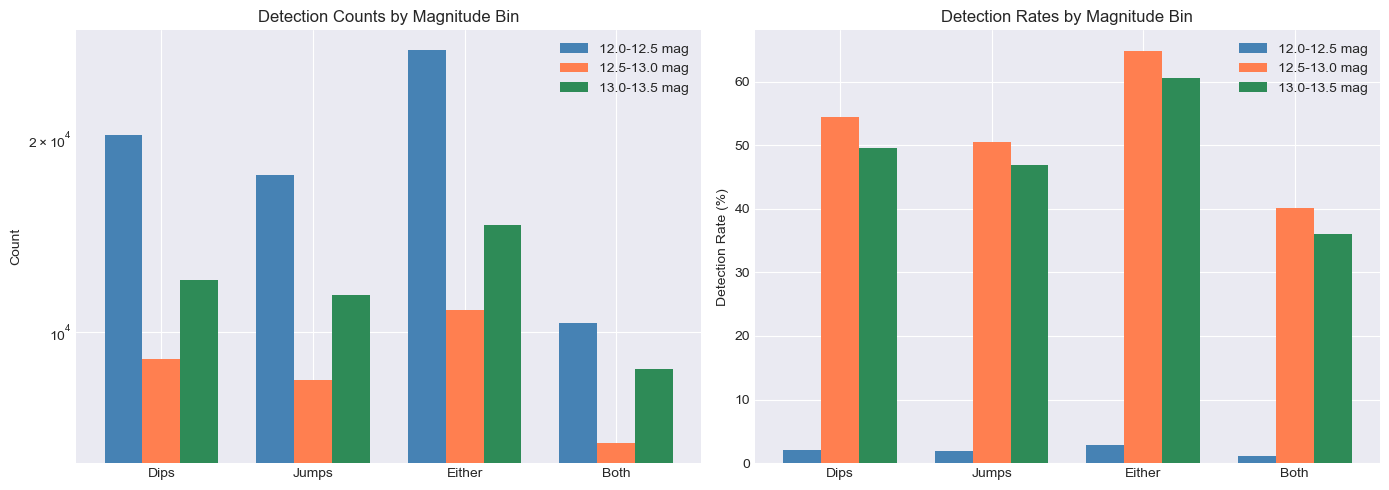

In [6]:
# Visual comparison of detection rates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of detection counts
x = np.arange(4)
width = 0.25
labels = ['Dips', 'Jumps', 'Either', 'Both']

bright_vals = [stats_bright['n_dip'], stats_bright['n_jump'], stats_bright['n_either'], stats_bright['n_both']]
mid_vals = [stats_mid['n_dip'], stats_mid['n_jump'], stats_mid['n_either'], stats_mid['n_both']]
faint_vals = [stats_faint['n_dip'], stats_faint['n_jump'], stats_faint['n_either'], stats_faint['n_both']]

bars1 = axes[0].bar(x - width, bright_vals, width, label='12.0-12.5 mag', color='steelblue')
bars2 = axes[0].bar(x, mid_vals, width, label='12.5-13.0 mag', color='coral')
bars3 = axes[0].bar(x + width, faint_vals, width, label='13.0-13.5 mag', color='seagreen')
axes[0].set_ylabel('Count')
axes[0].set_title('Detection Counts by Magnitude Bin')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend()
axes[0].set_yscale('log')

# Detection rates (percentage)
bright_rates = [v/stats_bright['n']*100 for v in bright_vals]
mid_rates = [v/stats_mid['n']*100 for v in mid_vals]
faint_rates = [v/stats_faint['n']*100 for v in faint_vals]

bars1 = axes[1].bar(x - width, bright_rates, width, label='12.0-12.5 mag', color='steelblue')
bars2 = axes[1].bar(x, mid_rates, width, label='12.5-13.0 mag', color='coral')
bars3 = axes[1].bar(x + width, faint_rates, width, label='13.0-13.5 mag', color='seagreen')
axes[1].set_ylabel('Detection Rate (%)')
axes[1].set_title('Detection Rates by Magnitude Bin')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].legend()

plt.tight_layout()
plt.show()

## 2.1 Key Detection Stage Counts

Progressive filtering stages:
1. **Dip Detected** (`dip_significant=True`): Light curves with statistically significant dip events
2. **Gaussian Morphology** (`dip_best_morph='gaussian'`): Dips with symmetric Gaussian shape
3. **Final Filter (cams>=2)**: Multi-camera confirmed dips (robust against instrumental artifacts)

KEY DETECTION STAGE COUNTS

Bright Sample (12.0-12.5 mag):
  Stage                                         Count   % of Total
  ---------------------------------------- ---------- ------------
  Total light curves                          950,519      100.00%
  (1) Dip detected (dip_significant)           20,315        2.14%
  (2) Gaussian dip morphology                  13,034        1.37%
  (3) Final filter (cams >= 2)                  4,792        0.50%
  (2) + (3) Gaussian AND cams >= 2              3,109        0.33%

Mid Sample (12.5-13.0 mag):
  Stage                                         Count   % of Total
  ---------------------------------------- ---------- ------------
  Total light curves                           16,692      100.00%
  (1) Dip detected (dip_significant)            9,085       54.43%
  (2) Gaussian dip morphology                   3,646       21.84%
  (3) Final filter (cams >= 2)                  2,613       15.65%
  (2) + (3) Gaussian AND cams >= 2       

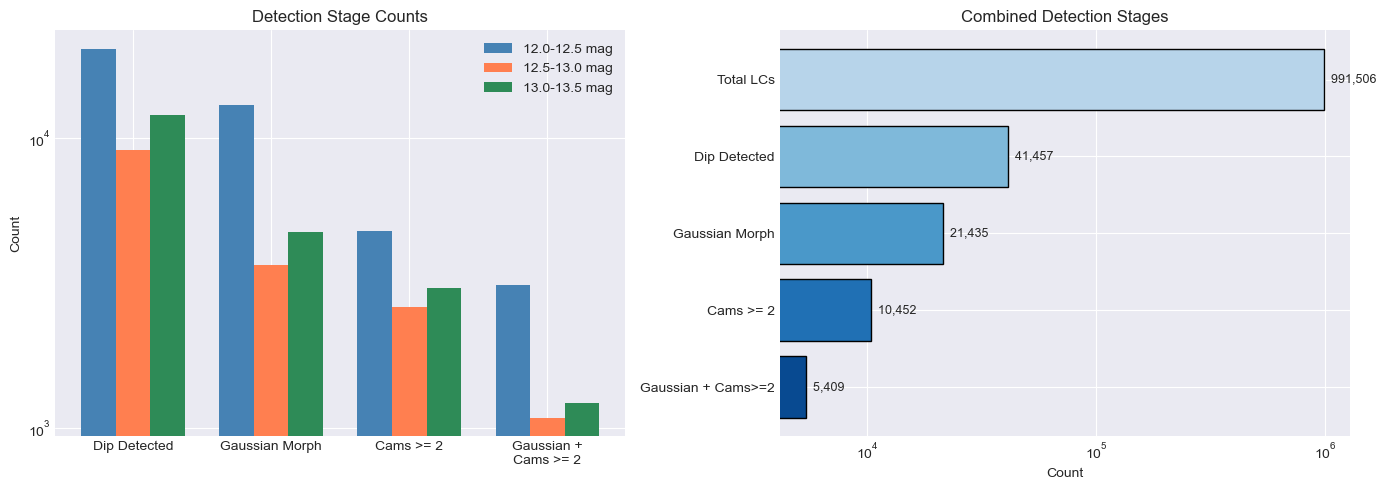

In [7]:
# Key detection stage counts
print("=" * 70)
print("KEY DETECTION STAGE COUNTS")
print("=" * 70)

def count_detection_stages(df, label):
    """Count light curves at each detection stage."""
    n_total = len(df)
    
    # Stage 1: Dip detected (dip_significant = True)
    n_dip_detected = df['dip_significant'].sum()
    
    # Stage 2: Gaussian dip morphology
    n_gaussian_morph = (df['dip_best_morph'] == 'gaussian').sum()
    
    # Stage 3: Final filter - multi-camera confirmed (cams >= 2)
    # This requires having a dip run with at least 2 cameras
    n_final_filter = (
        (df['dip_run_count'] >= 1) & 
        (df['dip_max_run_cameras'] >= 2)
    ).sum()
    
    # Intersection: Gaussian morphology AND multi-camera
    n_gaussian_multicam = (
        (df['dip_best_morph'] == 'gaussian') & 
        (df['dip_max_run_cameras'] >= 2)
    ).sum()
    
    print(f"\n{label}:")
    print(f"  {'Stage':<40} {'Count':>10} {'% of Total':>12}")
    print(f"  {'-'*40} {'-'*10} {'-'*12}")
    print(f"  {'Total light curves':<40} {n_total:>10,} {100.0:>11.2f}%")
    print(f"  {'(1) Dip detected (dip_significant)':<40} {n_dip_detected:>10,} {n_dip_detected/n_total*100:>11.2f}%")
    print(f"  {'(2) Gaussian dip morphology':<40} {n_gaussian_morph:>10,} {n_gaussian_morph/n_total*100:>11.2f}%")
    print(f"  {'(3) Final filter (cams >= 2)':<40} {n_final_filter:>10,} {n_final_filter/n_total*100:>11.2f}%")
    print(f"  {'(2) + (3) Gaussian AND cams >= 2':<40} {n_gaussian_multicam:>10,} {n_gaussian_multicam/n_total*100:>11.2f}%")
    
    return {
        'label': label,
        'total': n_total,
        'dip_detected': n_dip_detected,
        'gaussian_morph': n_gaussian_morph,
        'final_filter_cams2': n_final_filter,
        'gaussian_and_cams2': n_gaussian_multicam
    }

# Count for each sample
counts_bright = count_detection_stages(df_bright, "Bright Sample (12.0-12.5 mag)")
counts_mid = count_detection_stages(df_mid, "Mid Sample (12.5-13.0 mag)")
counts_faint = count_detection_stages(df_faint, "Faint Sample (13.0-13.5 mag)")
counts_combined = count_detection_stages(df_combined, "Combined")

# Visual comparison
print("\n" + "=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
stages = ['Dip Detected', 'Gaussian Morph', 'Cams >= 2', 'Gaussian +\nCams >= 2']
bright_vals = [counts_bright['dip_detected'], counts_bright['gaussian_morph'], 
               counts_bright['final_filter_cams2'], counts_bright['gaussian_and_cams2']]
mid_vals = [counts_mid['dip_detected'], counts_mid['gaussian_morph'], 
            counts_mid['final_filter_cams2'], counts_mid['gaussian_and_cams2']]
faint_vals = [counts_faint['dip_detected'], counts_faint['gaussian_morph'], 
              counts_faint['final_filter_cams2'], counts_faint['gaussian_and_cams2']]

x = np.arange(len(stages))
width = 0.25

bars1 = axes[0].bar(x - width, bright_vals, width, label='12.0-12.5 mag', color='steelblue')
bars2 = axes[0].bar(x, mid_vals, width, label='12.5-13.0 mag', color='coral')
bars3 = axes[0].bar(x + width, faint_vals, width, label='13.0-13.5 mag', color='seagreen')
axes[0].set_ylabel('Count')
axes[0].set_title('Detection Stage Counts')
axes[0].set_xticks(x)
axes[0].set_xticklabels(stages)
axes[0].legend()
axes[0].set_yscale('log')

# Combined funnel chart
combined_vals = [counts_combined['total'], counts_combined['dip_detected'], 
                 counts_combined['gaussian_morph'], counts_combined['final_filter_cams2'],
                 counts_combined['gaussian_and_cams2']]
combined_labels = ['Total LCs', 'Dip Detected', 'Gaussian Morph', 'Cams >= 2', 'Gaussian + Cams>=2']
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(combined_vals)))

bars = axes[1].barh(range(len(combined_vals)), combined_vals, color=colors, edgecolor='black')
axes[1].set_yticks(range(len(combined_vals)))
axes[1].set_yticklabels(combined_labels)
axes[1].set_xlabel('Count')
axes[1].set_title('Combined Detection Stages')
axes[1].set_xscale('log')
axes[1].invert_yaxis()

for bar, val in zip(bars, combined_vals):
    axes[1].text(val, bar.get_y() + bar.get_height()/2, f'  {val:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 2.2 Known Candidate Validation

Check if known candidates from Brayden's list are recovered by our filters.
Only checking candidates that fall within the magnitude bins of these datasets (12_12.5 and 12.5_13).

In [8]:
# Known candidates list
brayden_candidates = [
    {"source": "J042214+152530", "source_id": "377957522430", "category": "Dippers", "mag_bin": "13_13.5", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J202402+383938", "source_id": "42950993887", "category": "Dippers", "mag_bin": "13_13.5", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J174328+343315", "source_id": "223339338105", "category": "Dippers", "mag_bin": "13_13.5", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J080327-261620", "source_id": "601296043597", "category": "Dippers", "mag_bin": "13_13.5", "search_method": "Pipeline", "expected_detected": False},
    {"source": "J184916-473251", "source_id": "472447294641", "category": "Dippers", "mag_bin": "13_13.5", "search_method": "Known", "expected_detected": True},
    {"source": "J183153-284827", "source_id": "455267102087", "category": "Dippers", "mag_bin": "13.5_14", "search_method": "Known", "expected_detected": False},
    {"source": "J070519+061219", "source_id": "266288137752", "category": "Dippers", "mag_bin": "13.5_14", "search_method": "Known", "expected_detected": False},
    {"source": "J081523-385923", "source_id": "532576686103", "category": "Dippers", "mag_bin": "13.5_14", "search_method": "Known", "expected_detected": False},
    {"source": "J085816-430955", "source_id": "352187470767", "category": "Dippers", "mag_bin": "12_12.5", "search_method": "Known", "expected_detected": False},
    {"source": "J114712-621037", "source_id": "609886184506", "category": "Dippers", "mag_bin": "13_13.5", "search_method": "Known", "expected_detected": False},
    {"source": "J005437+644347", "source_id": "68720274411", "category": "Multiple Eclipse Binaries", "mag_bin": "13_13.5", "search_method": "Known", "expected_detected": True},
    {"source": "J062510-075341", "source_id": "377958261591", "category": "Multiple Eclipse Binaries", "mag_bin": "13.5_14", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J124745-622756", "source_id": "515397118400", "category": "Multiple Eclipse Binaries", "mag_bin": "13.5_14", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J175912-120956", "source_id": "326417831663", "category": "Multiple Eclipse Binaries", "mag_bin": "13_13.5", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J181752-580749", "source_id": "644245387906", "category": "Multiple Eclipse Binaries", "mag_bin": "12_12.5", "search_method": "Known", "expected_detected": True},
    {"source": "J160757-574540", "source_id": "661425129485", "category": "Multiple Eclipse Binaries", "mag_bin": "13.5_14", "search_method": "Pipeline", "expected_detected": False},
    {"source": "J073924-272916", "source_id": "438086977939", "category": "Single Eclipse Binaries", "mag_bin": "13.5_14", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J074007-161608", "source_id": "360777377116", "category": "Single Eclipse Binaries", "mag_bin": "13_13.5", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J094848-545959", "source_id": "635655234580", "category": "Single Eclipse Binaries", "mag_bin": "13_13.5", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J162209-444247", "source_id": "412317159120", "category": "Single Eclipse Binaries", "mag_bin": "13.5_14", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J183606-314826", "source_id": "438086901547", "category": "Single Eclipse Binaries", "mag_bin": "13.5_14", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J205245-713514", "source_id": "463856535113", "category": "Single Eclipse Binaries", "mag_bin": "13_13.5", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J212132+480140", "source_id": "120259184943", "category": "Single Eclipse Binaries", "mag_bin": "13_13.5", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J225702+562312", "source_id": "25770019815", "category": "Single Eclipse Binaries", "mag_bin": "13.5_14", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J190316-195739", "source_id": "515396514761", "category": "Single Eclipse Binaries", "mag_bin": "13.5_14", "search_method": "Pipeline", "expected_detected": True},
    {"source": "J175602+013135", "source_id": "231929175915", "category": "Single Eclipse Binaries", "mag_bin": "14_14.5", "search_method": "Known", "expected_detected": True},
    {"source": "J073234-200049", "source_id": "335007754417", "category": "Single Eclipse Binaries", "mag_bin": "14.5_15", "search_method": "Known", "expected_detected": True},
    {"source": "J223332+565552", "source_id": "60130040391", "category": "Single Eclipse Binaries", "mag_bin": "12.5_13", "search_method": "Known", "expected_detected": True},
    {"source": "J183210-173432", "source_id": "317827964025", "category": "Single Eclipse Binaries", "mag_bin": "12.5_13", "search_method": "Pipeline", "expected_detected": False},
]

# Filter to candidates in our magnitude bins (now includes 13_13.5)
relevant_mag_bins = ["12_12.5", "12.5_13", "13_13.5"]
relevant_candidates = [c for c in brayden_candidates if c["mag_bin"] in relevant_mag_bins]

print("=" * 80)
print("KNOWN CANDIDATE VALIDATION - ALL FILTERS (including Gaussian morphology)")
print("=" * 80)
print(f"\nCandidates in relevant mag bins ({relevant_mag_bins}): {len(relevant_candidates)}")

# Extract source_id from path (filename without .dat2)
df_combined['source_id'] = df_combined['path'].apply(lambda x: x.split('/')[-1].replace('.dat2', ''))

# Define ALL filters (strict)
def passes_all_filters(row):
    """Check if a light curve passes ALL filters including Gaussian morphology."""
    return (
        (row['dip_bayes_factor'] > 10) &
        (row['dip_max_event_prob'] > 0.5) &
        (row['dip_run_count'] >= 1) &
        (row['dip_max_run_points'] >= 2) &
        (row['dip_max_run_cameras'] >= 2) &
        (row['dip_best_morph'] in ['gaussian', 'skew_gaussian']) &
        (row['dip_best_delta_bic'] > 10)
    )

# Check each candidate
results_all_filters = []
for cand in relevant_candidates:
    source_id = cand["source_id"]
    mag_bin = cand["mag_bin"]
    
    # Select appropriate dataframe based on mag_bin
    if mag_bin == "12_12.5":
        df_check = df_bright
    elif mag_bin == "12.5_13":
        df_check = df_mid
    else:  # 13_13.5
        df_check = df_faint
    
    # Extract source_id for this dataframe
    df_check = df_check.copy()
    df_check['source_id'] = df_check['path'].apply(lambda x: x.split('/')[-1].replace('.dat2', ''))
    
    # Find the candidate
    match = df_check[df_check['source_id'] == source_id]
    
    if len(match) == 0:
        status = "NOT FOUND"
        passed = False
        details = "Source ID not in dataset"
    else:
        row = match.iloc[0]
        passed = passes_all_filters(row)
        status = "PASSED" if passed else "FAILED"
        details = f"BF={row['dip_bayes_factor']:.1f}, morph={row['dip_best_morph']}, cams={row['dip_max_run_cameras']}"
    
    results_all_filters.append({
        'source': cand['source'],
        'source_id': source_id,
        'category': cand['category'],
        'mag_bin': mag_bin,
        'expected': cand['expected_detected'],
        'passed': passed if len(match) > 0 else None,
        'status': status,
        'details': details
    })

# Display results
print(f"\n{'Source':<20} {'Category':<25} {'Mag Bin':<10} {'Expected':<10} {'Status':<12} {'Details'}")
print("-" * 120)
for r in results_all_filters:
    exp_str = "Yes" if r['expected'] else "No"
    match_icon = ""
    if r['status'] != "NOT FOUND":
        if r['passed'] == r['expected']:
            match_icon = "OK"
        else:
            match_icon = "MISMATCH"
    print(f"{r['source']:<20} {r['category']:<25} {r['mag_bin']:<10} {exp_str:<10} {r['status']:<12} {r['details']:<40} {match_icon}")

# Summary
n_found = sum(1 for r in results_all_filters if r['status'] != "NOT FOUND")
n_passed = sum(1 for r in results_all_filters if r['status'] == "PASSED")
n_expected_pass = sum(1 for r in results_all_filters if r['expected'] and r['status'] != "NOT FOUND")
n_correct = sum(1 for r in results_all_filters if r['status'] != "NOT FOUND" and r['passed'] == r['expected'])

print(f"\n{'='*80}")
print(f"SUMMARY (ALL FILTERS):")
print(f"  Candidates in mag bins: {len(relevant_candidates)}")
print(f"  Found in data:          {n_found}")
print(f"  Passed all filters:     {n_passed}")
print(f"  Expected to pass:       {n_expected_pass}")
correct_pct = f"{n_correct/n_found*100:.1f}%" if n_found > 0 else "N/A"
print(f"  Correct predictions:    {n_correct}/{n_found} ({correct_pct})")
print(f"{'='*80}")

KNOWN CANDIDATE VALIDATION - ALL FILTERS (including Gaussian morphology)

Candidates in relevant mag bins (['12_12.5', '12.5_13', '13_13.5']): 16

Source               Category                  Mag Bin    Expected   Status       Details
------------------------------------------------------------------------------------------------------------------------
J042214+152530       Dippers                   13_13.5    Yes        FAILED       BF=661.4, morph=gaussian, cams=1         MISMATCH
J202402+383938       Dippers                   13_13.5    Yes        FAILED       BF=3849.8, morph=noise, cams=2           MISMATCH
J174328+343315       Dippers                   13_13.5    Yes        NOT FOUND    Source ID not in dataset                 
J080327-261620       Dippers                   13_13.5    No         FAILED       BF=5587.2, morph=noise, cams=4           OK
J184916-473251       Dippers                   13_13.5    Yes        NOT FOUND    Source ID not in dataset                 
J085

KNOWN CANDIDATE VALIDATION - WITHOUT GAUSSIAN FILTER
(All other filters still applied: BF>10, prob>0.5, runs>=1, pts>=2, cams>=2)

Source               Category                  Mag Bin    Expected   No Morph   All Filt   Details
----------------------------------------------------------------------------------------------------------------------------------
J042214+152530       Dippers                   13_13.5    Yes        FAILED     FAILED     BF=661.4, runs=1, cams=1, morph=gaussian      
J202402+383938       Dippers                   13_13.5    Yes        PASSED     FAILED     BF=3849.8, runs=12, cams=2, morph=noise       <-- MORPH FILTER REMOVED THIS
J174328+343315       Dippers                   13_13.5    Yes        N/A        N/A        Source ID not in dataset                      
J080327-261620       Dippers                   13_13.5    No         PASSED     FAILED     BF=5587.2, runs=12, cams=4, morph=noise       <-- MORPH FILTER REMOVED THIS
J184916-473251       Dippers 

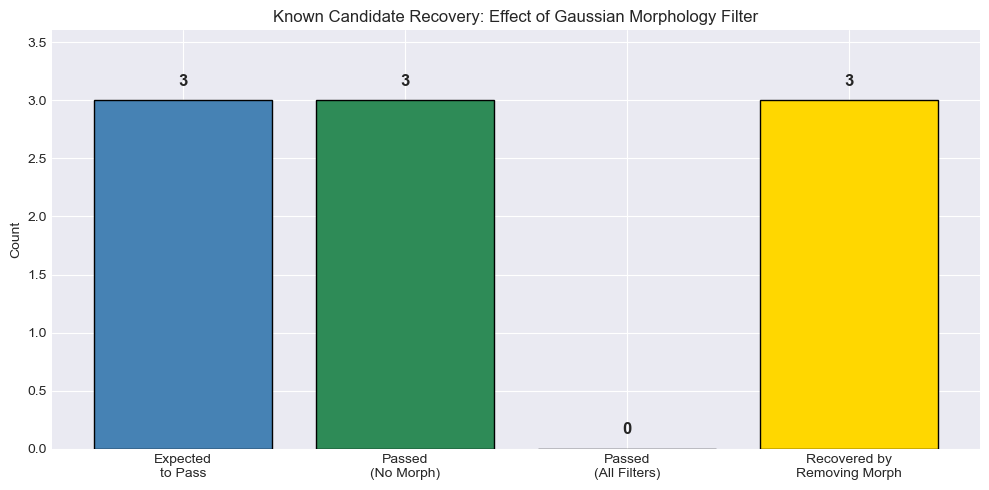

In [9]:
# Check candidates WITHOUT Gaussian morphology filter
print("=" * 80)
print("KNOWN CANDIDATE VALIDATION - WITHOUT GAUSSIAN FILTER")
print("(All other filters still applied: BF>10, prob>0.5, runs>=1, pts>=2, cams>=2)")
print("=" * 80)

# Define filters WITHOUT morphology requirement
def passes_filters_no_morph(row):
    """Check if a light curve passes all filters EXCEPT Gaussian morphology."""
    return (
        (row['dip_bayes_factor'] > 10) &
        (row['dip_max_event_prob'] > 0.5) &
        (row['dip_run_count'] >= 1) &
        (row['dip_max_run_points'] >= 2) &
        (row['dip_max_run_cameras'] >= 2)
        # NO morphology filter
        # NO delta BIC filter (since that's tied to morphology fitting)
    )

# Check each candidate
results_no_morph = []
for cand in relevant_candidates:
    source_id = cand["source_id"]
    mag_bin = cand["mag_bin"]
    
    # Select appropriate dataframe based on mag_bin
    if mag_bin == "12_12.5":
        df_check = df_bright
    elif mag_bin == "12.5_13":
        df_check = df_mid
    else:  # 13_13.5
        df_check = df_faint
    
    # Extract source_id for this dataframe
    df_check = df_check.copy()
    df_check['source_id'] = df_check['path'].apply(lambda x: x.split('/')[-1].replace('.dat2', ''))
    
    # Find the candidate
    match = df_check[df_check['source_id'] == source_id]
    
    if len(match) == 0:
        status = "NOT FOUND"
        passed = False
        passed_all = False
        details = "Source ID not in dataset"
    else:
        row = match.iloc[0]
        passed = passes_filters_no_morph(row)
        passed_all = passes_all_filters(row)
        status = "PASSED" if passed else "FAILED"
        details = f"BF={row['dip_bayes_factor']:.1f}, runs={row['dip_run_count']}, cams={row['dip_max_run_cameras']}, morph={row['dip_best_morph']}"
    
    results_no_morph.append({
        'source': cand['source'],
        'source_id': source_id,
        'category': cand['category'],
        'mag_bin': mag_bin,
        'expected': cand['expected_detected'],
        'passed_no_morph': passed if len(match) > 0 else None,
        'passed_all': passed_all if len(match) > 0 else None,
        'status': status,
        'details': details
    })

# Display results with comparison
print(f"\n{'Source':<20} {'Category':<25} {'Mag Bin':<10} {'Expected':<10} {'No Morph':<10} {'All Filt':<10} {'Details'}")
print("-" * 130)
for r in results_no_morph:
    exp_str = "Yes" if r['expected'] else "No"
    no_morph_str = "PASSED" if r['passed_no_morph'] else ("FAILED" if r['passed_no_morph'] is not None else "N/A")
    all_filt_str = "PASSED" if r['passed_all'] else ("FAILED" if r['passed_all'] is not None else "N/A")
    
    # Highlight cases where removing morph filter changes result
    highlight = ""
    if r['passed_no_morph'] is not None and r['passed_all'] is not None:
        if r['passed_no_morph'] and not r['passed_all']:
            highlight = "<-- MORPH FILTER REMOVED THIS"
    
    print(f"{r['source']:<20} {r['category']:<25} {r['mag_bin']:<10} {exp_str:<10} {no_morph_str:<10} {all_filt_str:<10} {r['details']:<45} {highlight}")

# Summary comparison
n_found = sum(1 for r in results_no_morph if r['status'] != "NOT FOUND")
n_passed_no_morph = sum(1 for r in results_no_morph if r['passed_no_morph'])
n_passed_all = sum(1 for r in results_no_morph if r['passed_all'])
n_recovered_by_removing_morph = sum(1 for r in results_no_morph if r['passed_no_morph'] and not r['passed_all'])

print(f"\n{'='*80}")
print(f"SUMMARY COMPARISON:")
print(f"  Candidates in mag bins:            {len(relevant_candidates)}")
print(f"  Found in data:                     {n_found}")
print(f"  Passed WITHOUT morph filter:       {n_passed_no_morph}")
print(f"  Passed WITH all filters:           {n_passed_all}")
print(f"  Recovered by removing morph filter: {n_recovered_by_removing_morph}")
print(f"{'='*80}")

# Visual comparison
if n_found > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    categories = ['Expected\nto Pass', 'Passed\n(No Morph)', 'Passed\n(All Filters)', 'Recovered by\nRemoving Morph']
    n_expected = sum(1 for r in results_no_morph if r['expected'] and r['status'] != "NOT FOUND")
    values = [n_expected, n_passed_no_morph, n_passed_all, n_recovered_by_removing_morph]
    colors = ['steelblue', 'seagreen', 'coral', 'gold']
    
    bars = ax.bar(categories, values, color=colors, edgecolor='black')
    ax.set_ylabel('Count')
    ax.set_title('Known Candidate Recovery: Effect of Gaussian Morphology Filter')
    
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, str(val), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylim(0, max(values) * 1.2 if max(values) > 0 else 1)
    plt.tight_layout()
    plt.show()

## 3. Light Curve Quality Metrics

Key quality metrics that affect detection sensitivity:
- `n_points`: Number of photometric measurements
- `cadence_median_days`: Typical time between observations
- `n_cameras`: Number of ASAS-SN cameras with data (multi-camera detections are more robust)
- Time span: Total observation baseline

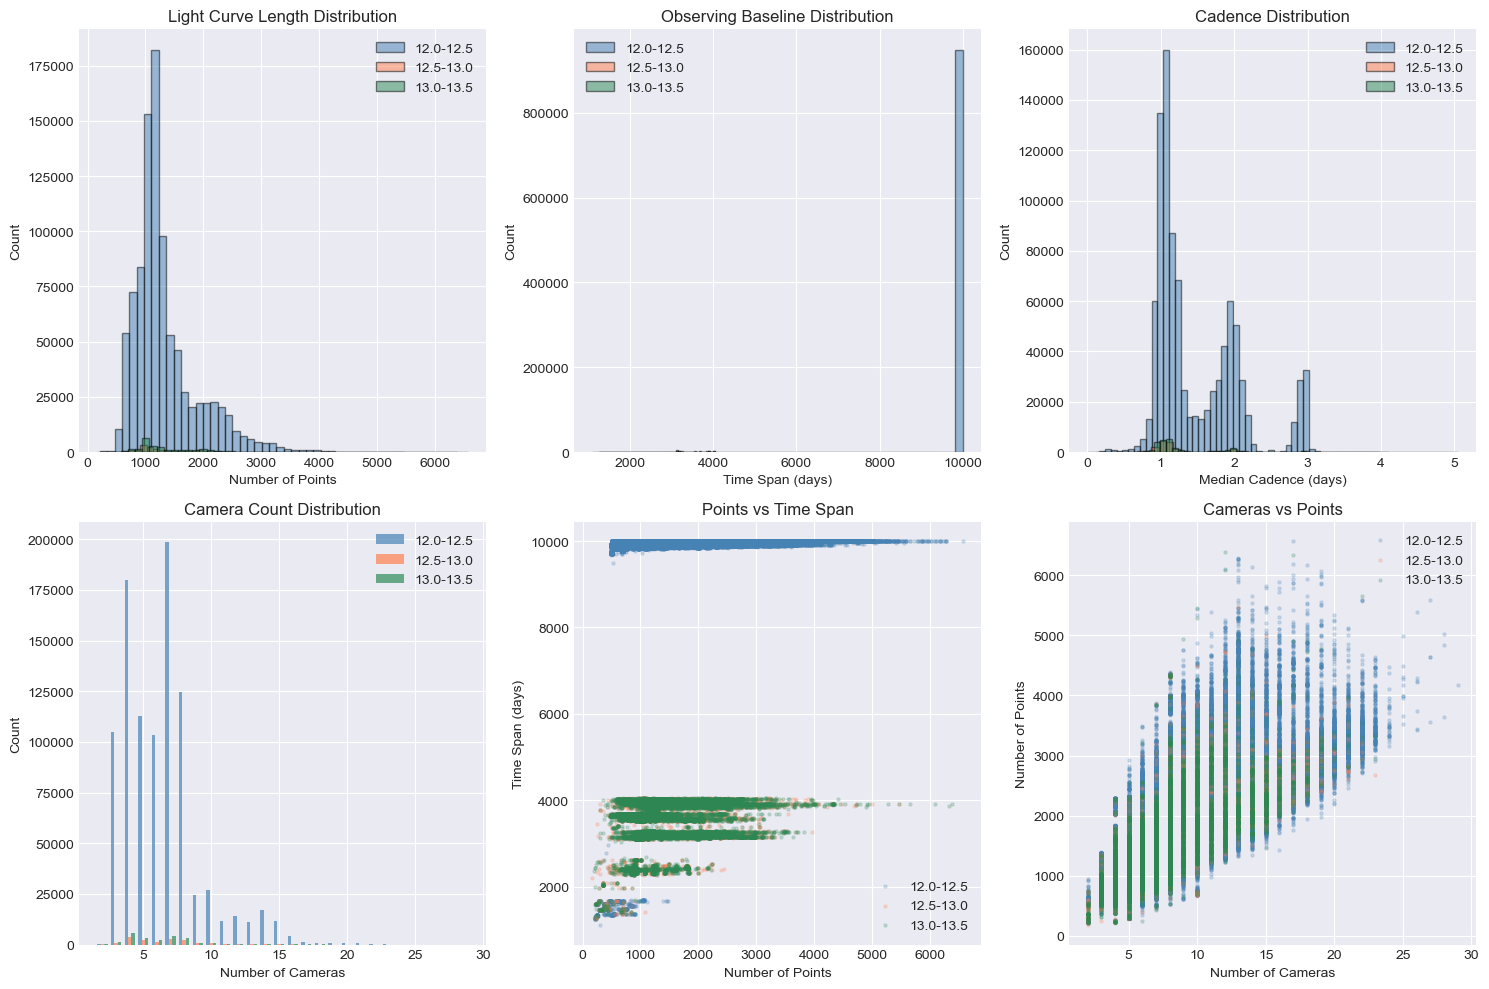

In [10]:
# Calculate time span
df_combined['time_span_days'] = df_combined['jd_last'] - df_combined['jd_first']
df_bright['time_span_days'] = df_bright['jd_last'] - df_bright['jd_first']
df_mid['time_span_days'] = df_mid['jd_last'] - df_mid['jd_first']
df_faint['time_span_days'] = df_faint['jd_last'] - df_faint['jd_first']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Define datasets for iteration
plot_datasets = [(df_bright, '12.0-12.5', 'steelblue'), (df_mid, '12.5-13.0', 'coral'), (df_faint, '13.0-13.5', 'seagreen')]

# n_points distribution
for df, label, color in plot_datasets:
    axes[0, 0].hist(df['n_points'], bins=50, alpha=0.5, label=label, edgecolor='black', color=color)
axes[0, 0].set_xlabel('Number of Points')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Light Curve Length Distribution')
axes[0, 0].legend()

# Time span distribution
for df, label, color in plot_datasets:
    axes[0, 1].hist(df['time_span_days'], bins=50, alpha=0.5, label=label, edgecolor='black', color=color)
axes[0, 1].set_xlabel('Time Span (days)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Observing Baseline Distribution')
axes[0, 1].legend()

# Cadence distribution
for df, label, color in plot_datasets:
    axes[0, 2].hist(df['cadence_median_days'], bins=50, alpha=0.5, label=label, edgecolor='black', color=color)
axes[0, 2].set_xlabel('Median Cadence (days)')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Cadence Distribution')
axes[0, 2].legend()

# n_cameras distribution
for i, (df, label, color) in enumerate(plot_datasets):
    cam_counts = df['n_cameras'].value_counts().sort_index()
    axes[1, 0].bar(cam_counts.index + i*0.25 - 0.25, cam_counts.values, width=0.25, label=label, alpha=0.7, color=color)
axes[1, 0].set_xlabel('Number of Cameras')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Camera Count Distribution')
axes[1, 0].legend()

# Points vs time span scatter
for df, label, color in plot_datasets:
    axes[1, 1].scatter(df['n_points'], df['time_span_days'], alpha=0.2, s=5, label=label, color=color)
axes[1, 1].set_xlabel('Number of Points')
axes[1, 1].set_ylabel('Time Span (days)')
axes[1, 1].set_title('Points vs Time Span')
axes[1, 1].legend()

# Cameras vs points scatter
for df, label, color in plot_datasets:
    axes[1, 2].scatter(df['n_cameras'], df['n_points'], alpha=0.2, s=5, label=label, color=color)
axes[1, 2].set_xlabel('Number of Cameras')
axes[1, 2].set_ylabel('Number of Points')
axes[1, 2].set_title('Cameras vs Points')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

In [11]:
# Summary statistics for quality metrics
quality_cols = ['n_points', 'time_span_days', 'cadence_median_days', 'n_cameras']

print("=== Quality Metrics: Bright Sample (12.0-12.5 mag) ===")
print(df_bright[quality_cols].describe().round(2))
print()
print("=== Quality Metrics: Mid Sample (12.5-13.0 mag) ===")
print(df_mid[quality_cols].describe().round(2))
print()
print("=== Quality Metrics: Faint Sample (13.0-13.5 mag) ===")
print(df_faint[quality_cols].describe().round(2))

=== Quality Metrics: Bright Sample (12.0-12.5 mag) ===
        n_points  time_span_days  cadence_median_days  n_cameras
count  950519.00       950519.00            950519.00  950519.00
mean     1329.60         9962.97                 1.48       6.43
std       567.22          254.84                 0.59       2.84
min       215.00         1101.98                 0.00       2.00
25%       993.00         9939.43                 1.04       4.00
50%      1176.00         9995.71                 1.20       6.00
75%      1500.00         9998.91                 1.90       8.00
max      6571.00         9999.99                 3.97      29.00

=== Quality Metrics: Mid Sample (12.5-13.0 mag) ===
       n_points  time_span_days  cadence_median_days  n_cameras
count  16692.00        16692.00             16692.00   16692.00
mean    1393.12         3438.35                 1.29       6.69
std      579.77          458.57                 0.50       2.96
min      171.00         1257.88                 0.1

## 4. Bayesian Detection Metrics

The pipeline uses Bayesian hypothesis testing to detect events:

- **`dip_bayes_factor`**: Global evidence ratio for dip vs baseline model (BF > 10 is "strong evidence")
- **`dip_max_event_prob`**: Maximum per-point probability of being in an event
- **`dip_max_log_bf_local`**: Maximum per-point log Bayes factor

Typical thresholds:
- Bayes Factor > 10-20 for significance
- Event probability > 0.5-0.99 depending on strictness

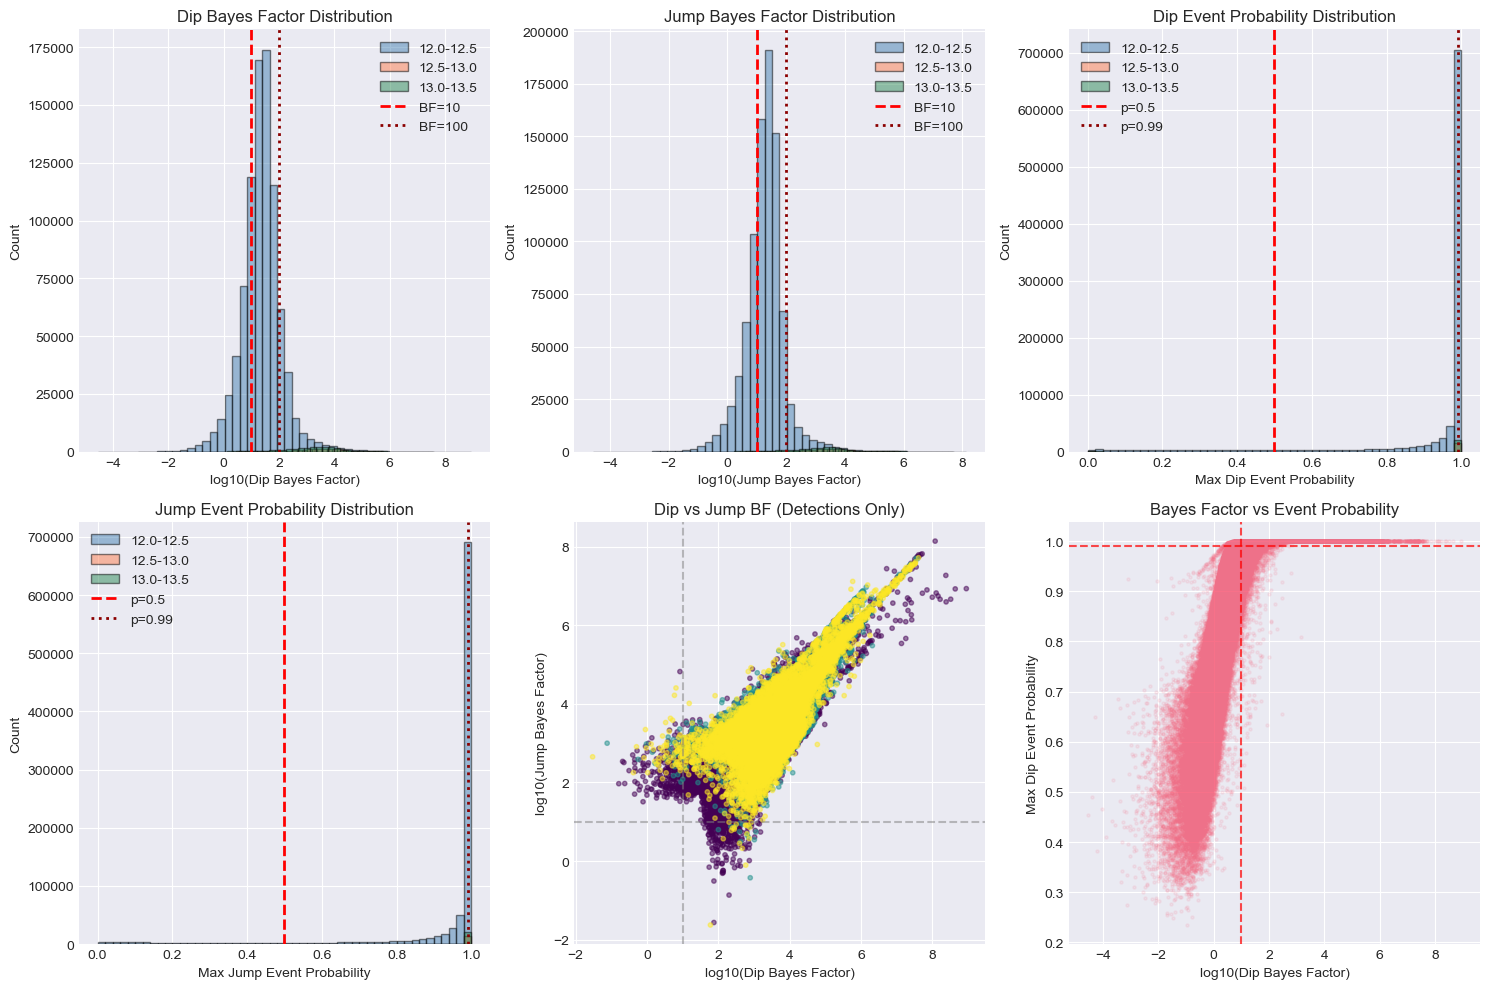

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Define datasets for iteration
plot_datasets = [(df_bright, '12.0-12.5', 'steelblue'), (df_mid, '12.5-13.0', 'coral'), (df_faint, '13.0-13.5', 'seagreen')]

# Dip Bayes Factor (log scale)
for df, label, color in plot_datasets:
    bf_log = np.log10(df['dip_bayes_factor'].replace(0, np.nan).dropna())
    bf_log = bf_log[np.isfinite(bf_log)]
    axes[0, 0].hist(bf_log, bins=50, alpha=0.5, label=label, edgecolor='black', color=color)
axes[0, 0].axvline(np.log10(10), color='red', linestyle='--', lw=2, label='BF=10')
axes[0, 0].axvline(np.log10(100), color='darkred', linestyle=':', lw=2, label='BF=100')
axes[0, 0].set_xlabel('log10(Dip Bayes Factor)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Dip Bayes Factor Distribution')
axes[0, 0].legend()

# Jump Bayes Factor (log scale)
for df, label, color in plot_datasets:
    bf_log = np.log10(df['jump_bayes_factor'].replace(0, np.nan).dropna())
    bf_log = bf_log[np.isfinite(bf_log)]
    axes[0, 1].hist(bf_log, bins=50, alpha=0.5, label=label, edgecolor='black', color=color)
axes[0, 1].axvline(np.log10(10), color='red', linestyle='--', lw=2, label='BF=10')
axes[0, 1].axvline(np.log10(100), color='darkred', linestyle=':', lw=2, label='BF=100')
axes[0, 1].set_xlabel('log10(Jump Bayes Factor)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Jump Bayes Factor Distribution')
axes[0, 1].legend()

# Dip max event probability
for df, label, color in plot_datasets:
    axes[0, 2].hist(df['dip_max_event_prob'], bins=50, alpha=0.5, label=label, edgecolor='black', color=color)
axes[0, 2].axvline(0.5, color='red', linestyle='--', lw=2, label='p=0.5')
axes[0, 2].axvline(0.99, color='darkred', linestyle=':', lw=2, label='p=0.99')
axes[0, 2].set_xlabel('Max Dip Event Probability')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Dip Event Probability Distribution')
axes[0, 2].legend()

# Jump max event probability
for df, label, color in plot_datasets:
    axes[1, 0].hist(df['jump_max_event_prob'], bins=50, alpha=0.5, label=label, edgecolor='black', color=color)
axes[1, 0].axvline(0.5, color='red', linestyle='--', lw=2, label='p=0.5')
axes[1, 0].axvline(0.99, color='darkred', linestyle=':', lw=2, label='p=0.99')
axes[1, 0].set_xlabel('Max Jump Event Probability')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Jump Event Probability Distribution')
axes[1, 0].legend()

# Dip vs Jump Bayes Factor correlation (for detections)
mask_detected = (df_combined['dip_significant'] | df_combined['jump_significant'])
df_detected = df_combined[mask_detected]
scatter = axes[1, 1].scatter(
    np.log10(df_detected['dip_bayes_factor'].replace(0, 1)),
    np.log10(df_detected['jump_bayes_factor'].replace(0, 1)),
    c=df_detected['mag_bin'].map({'12.0-12.5': 0, '12.5-13.0': 1, '13.0-13.5': 2}),
    alpha=0.5, s=10, cmap='viridis'
)
axes[1, 1].axhline(np.log10(10), color='gray', linestyle='--', alpha=0.5)
axes[1, 1].axvline(np.log10(10), color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('log10(Dip Bayes Factor)')
axes[1, 1].set_ylabel('log10(Jump Bayes Factor)')
axes[1, 1].set_title('Dip vs Jump BF (Detections Only)')

# Bayes Factor vs Event Probability
axes[1, 2].scatter(
    np.log10(df_combined['dip_bayes_factor'].replace(0, 1)),
    df_combined['dip_max_event_prob'],
    alpha=0.1, s=5
)
axes[1, 2].axhline(0.99, color='red', linestyle='--', alpha=0.7)
axes[1, 2].axvline(np.log10(10), color='red', linestyle='--', alpha=0.7)
axes[1, 2].set_xlabel('log10(Dip Bayes Factor)')
axes[1, 2].set_ylabel('Max Dip Event Probability')
axes[1, 2].set_title('Bayes Factor vs Event Probability')

plt.tight_layout()
plt.show()

## 5. Run Analysis (Temporal Clustering)

A "run" is a cluster of temporally-adjacent trigger points (points with high event probability).

Robust detections require:
- **`dip_run_count >= 1`**: At least one run detected
- **`dip_max_run_points >= 2`**: At least 2 points in the best run (not isolated noise)
- **`dip_max_run_cameras >= 2`**: Multi-camera confirmation (rules out instrumental artifacts)

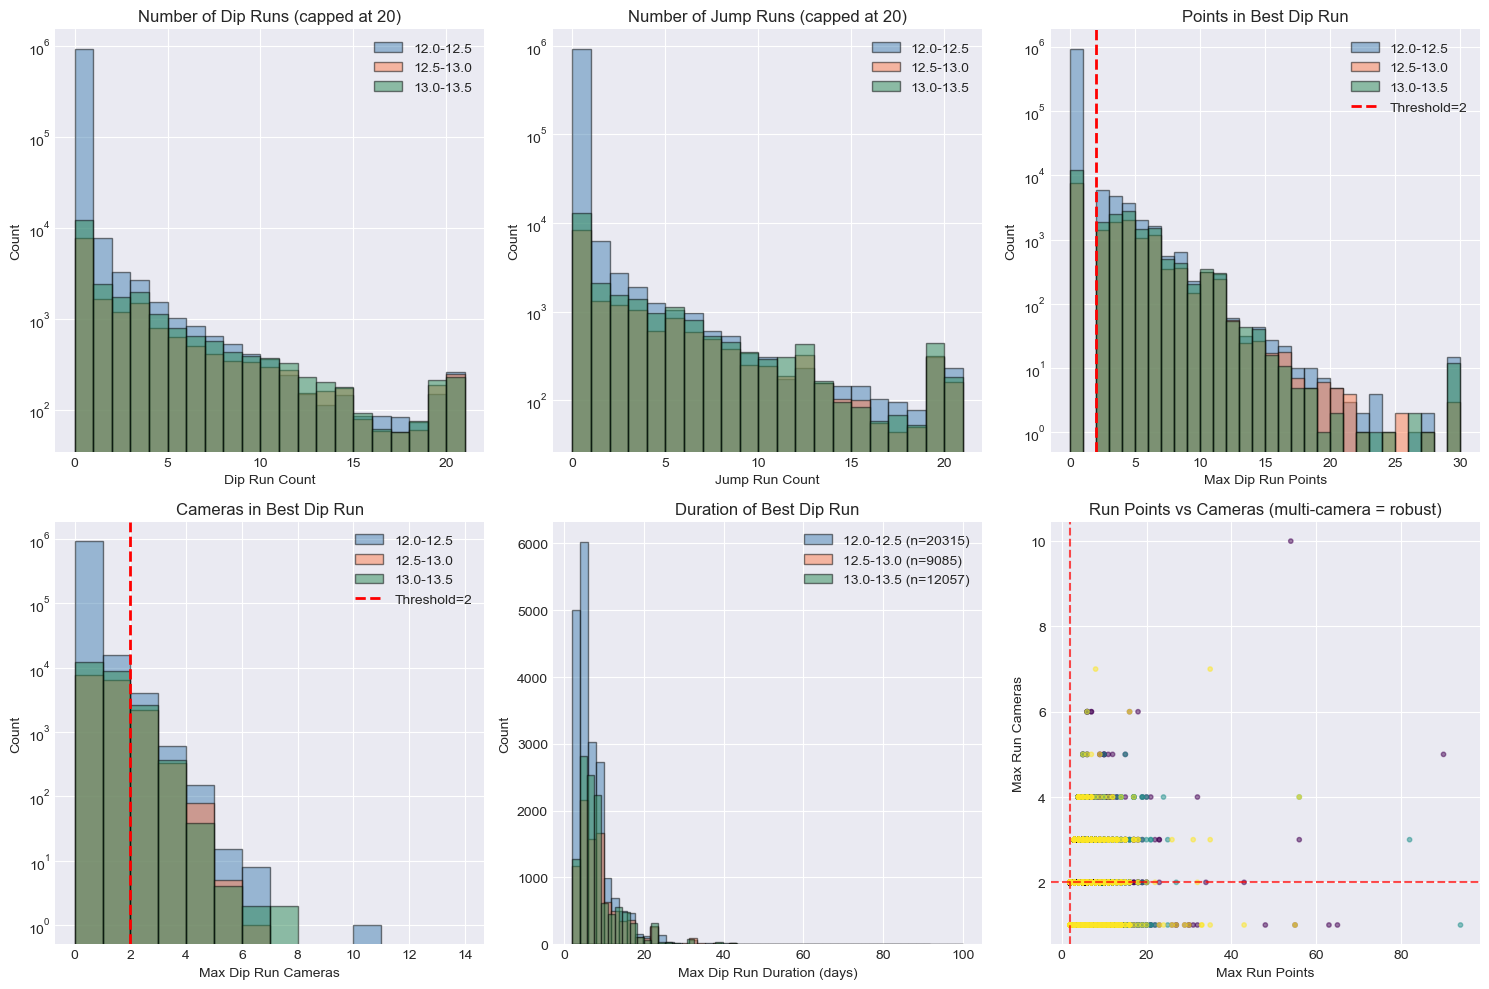

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Define datasets for iteration
plot_datasets = [(df_bright, '12.0-12.5', 'steelblue'), (df_mid, '12.5-13.0', 'coral'), (df_faint, '13.0-13.5', 'seagreen')]

# Dip run count
max_runs = 20
for df, label, color in plot_datasets:
    run_counts = df['dip_run_count'].clip(upper=max_runs)
    axes[0, 0].hist(run_counts, bins=range(0, max_runs+2), alpha=0.5, label=label, edgecolor='black', color=color)
axes[0, 0].set_xlabel('Dip Run Count')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title(f'Number of Dip Runs (capped at {max_runs})')
axes[0, 0].set_yscale('log')
axes[0, 0].legend()

# Jump run count
for df, label, color in plot_datasets:
    run_counts = df['jump_run_count'].clip(upper=max_runs)
    axes[0, 1].hist(run_counts, bins=range(0, max_runs+2), alpha=0.5, label=label, edgecolor='black', color=color)
axes[0, 1].set_xlabel('Jump Run Count')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title(f'Number of Jump Runs (capped at {max_runs})')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()

# Max run points (dip)
for df, label, color in plot_datasets:
    axes[0, 2].hist(df['dip_max_run_points'].clip(upper=30), bins=30, alpha=0.5, label=label, edgecolor='black', color=color)
axes[0, 2].axvline(2, color='red', linestyle='--', lw=2, label='Threshold=2')
axes[0, 2].set_xlabel('Max Dip Run Points')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Points in Best Dip Run')
axes[0, 2].set_yscale('log')
axes[0, 2].legend()

# Max run cameras (dip)
for df, label, color in plot_datasets:
    axes[1, 0].hist(df['dip_max_run_cameras'], bins=range(0, 15), alpha=0.5, label=label, edgecolor='black', color=color)
axes[1, 0].axvline(2, color='red', linestyle='--', lw=2, label='Threshold=2')
axes[1, 0].set_xlabel('Max Dip Run Cameras')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Cameras in Best Dip Run')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()

# Run duration (for those with runs)
for df, label, color in plot_datasets:
    duration = df['dip_max_run_duration'].dropna()
    if len(duration) > 0:
        axes[1, 1].hist(duration.clip(upper=100), bins=50, alpha=0.5, label=f'{label} (n={len(duration)})', edgecolor='black', color=color)
axes[1, 1].set_xlabel('Max Dip Run Duration (days)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Duration of Best Dip Run')
axes[1, 1].legend()

# Run points vs cameras correlation
df_with_runs = df_combined[df_combined['dip_run_count'] > 0]
scatter = axes[1, 2].scatter(
    df_with_runs['dip_max_run_points'],
    df_with_runs['dip_max_run_cameras'],
    c=df_with_runs['mag_bin'].map({'12.0-12.5': 0, '12.5-13.0': 1, '13.0-13.5': 2}),
    alpha=0.5, s=10, cmap='viridis'
)
axes[1, 2].axhline(2, color='red', linestyle='--', alpha=0.7)
axes[1, 2].axvline(2, color='red', linestyle='--', alpha=0.7)
axes[1, 2].set_xlabel('Max Run Points')
axes[1, 2].set_ylabel('Max Run Cameras')
axes[1, 2].set_title('Run Points vs Cameras (multi-camera = robust)')

plt.tight_layout()
plt.show()

In [14]:
# Run statistics summary
print("=== Run Statistics Summary ===")
for df, label in [(df_bright, 'Bright (12.0-12.5)'), (df_mid, 'Mid (12.5-13.0)'), (df_faint, 'Faint (13.0-13.5)')]:
    n = len(df)
    has_dip_run = (df['dip_run_count'] >= 1).sum()
    has_jump_run = (df['jump_run_count'] >= 1).sum()
    multi_cam_dip = (df['dip_max_run_cameras'] >= 2).sum()
    multi_point_dip = (df['dip_max_run_points'] >= 2).sum()
    robust_dip = ((df['dip_run_count'] >= 1) & (df['dip_max_run_cameras'] >= 2) & (df['dip_max_run_points'] >= 2)).sum()
    
    print(f"\n{label}:")
    print(f"  Has dip run (count >= 1):       {has_dip_run:>7,} ({has_dip_run/n*100:5.2f}%)")
    print(f"  Has jump run (count >= 1):      {has_jump_run:>7,} ({has_jump_run/n*100:5.2f}%)")
    print(f"  Multi-camera dip (cams >= 2):   {multi_cam_dip:>7,} ({multi_cam_dip/n*100:5.2f}%)")
    print(f"  Multi-point dip (pts >= 2):     {multi_point_dip:>7,} ({multi_point_dip/n*100:5.2f}%)")
    print(f"  Robust dip (all criteria):      {robust_dip:>7,} ({robust_dip/n*100:5.2f}%)")

=== Run Statistics Summary ===

Bright (12.0-12.5):
  Has dip run (count >= 1):        20,315 ( 2.14%)
  Has jump run (count >= 1):       17,614 ( 1.85%)
  Multi-camera dip (cams >= 2):     4,792 ( 0.50%)
  Multi-point dip (pts >= 2):      20,315 ( 2.14%)
  Robust dip (all criteria):        4,792 ( 0.50%)

Mid (12.5-13.0):
  Has dip run (count >= 1):         9,085 (54.43%)
  Has jump run (count >= 1):        8,426 (50.48%)
  Multi-camera dip (cams >= 2):     2,613 (15.65%)
  Multi-point dip (pts >= 2):       9,085 (54.43%)
  Robust dip (all criteria):        2,613 (15.65%)

Faint (13.0-13.5):
  Has dip run (count >= 1):        12,057 (49.63%)
  Has jump run (count >= 1):       11,408 (46.96%)
  Multi-camera dip (cams >= 2):     3,047 (12.54%)
  Multi-point dip (pts >= 2):      12,057 (49.63%)
  Robust dip (all criteria):        3,047 (12.54%)


## 6. Morphology Analysis

After detecting runs, the pipeline fits morphological models to classify the event shape:

- **`gaussian`**: Symmetric dip - could be disk occultation or eclipsing binary
- **`skew_gaussian`**: Asymmetric dip - characteristic of disk occultations (slower ingress/egress)
- **`paczynski`**: Microlensing curve (for jumps)
- **`none`**: No good fit found

**`dip_best_delta_bic`**: BIC improvement over baseline. Values > 10 indicate strong morphological fit.

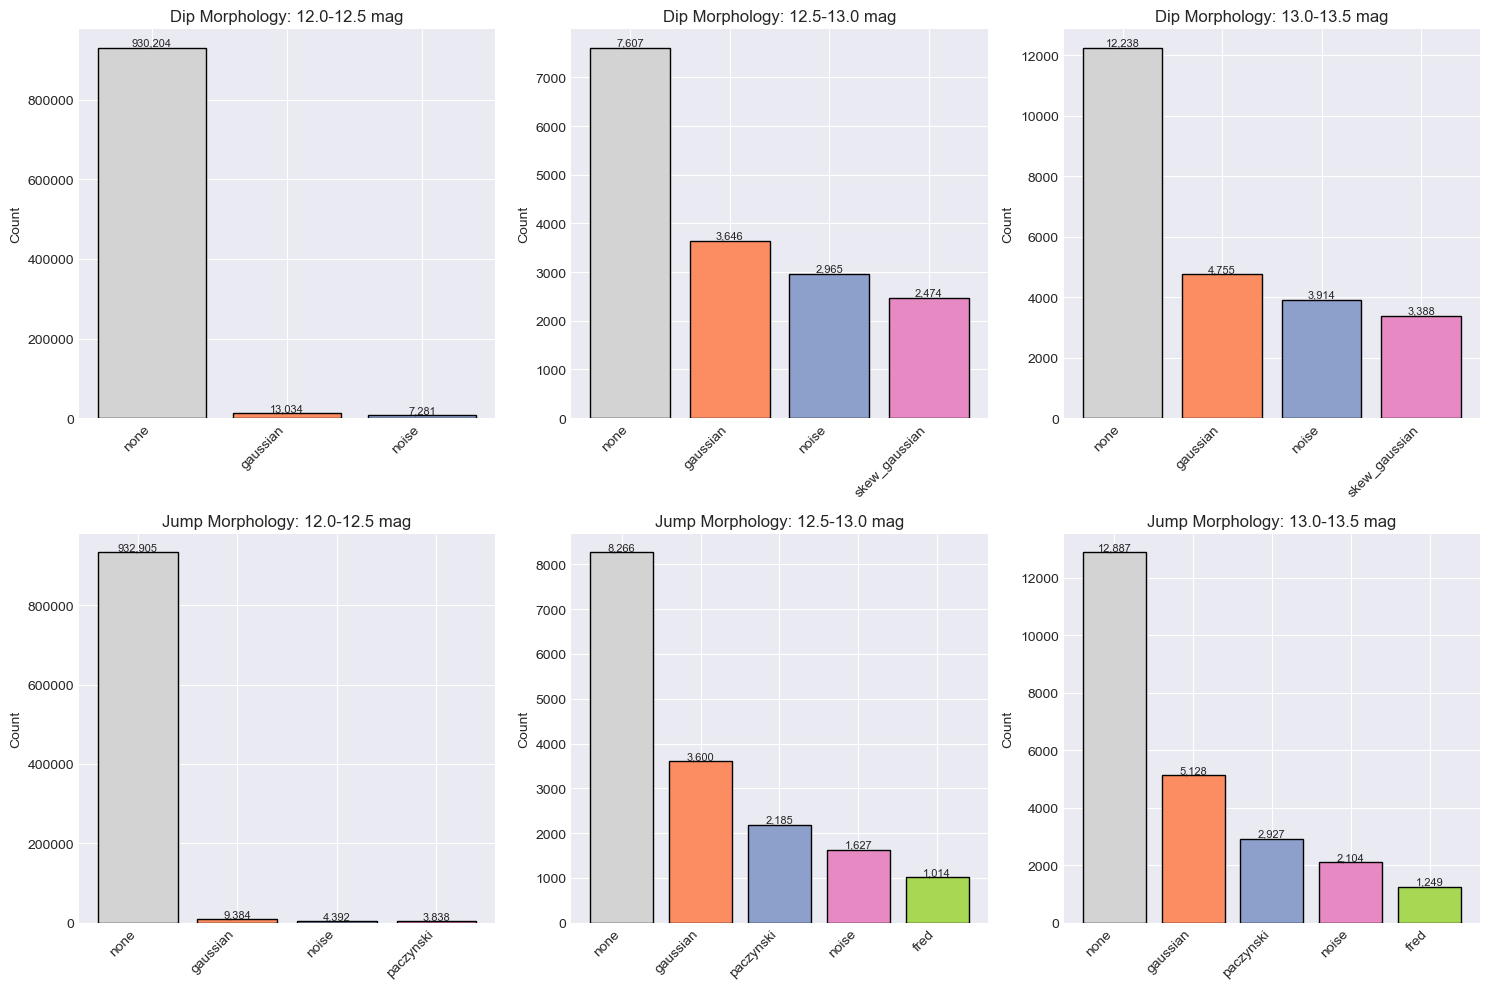

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Dip morphology counts
for i, (df, label) in enumerate([(df_bright, '12.0-12.5'), (df_mid, '12.5-13.0'), (df_faint, '13.0-13.5')]):
    morph_counts = df['dip_best_morph'].value_counts()
    colors = ['lightgray' if m == 'none' else plt.cm.Set2(j) for j, m in enumerate(morph_counts.index)]
    bars = axes[0, i].bar(range(len(morph_counts)), morph_counts.values, color=colors, edgecolor='black')
    axes[0, i].set_xticks(range(len(morph_counts)))
    axes[0, i].set_xticklabels(morph_counts.index, rotation=45, ha='right')
    axes[0, i].set_ylabel('Count')
    axes[0, i].set_title(f'Dip Morphology: {label} mag')
    # Add count labels
    for bar, count in zip(bars, morph_counts.values):
        axes[0, i].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}', 
                        ha='center', va='bottom', fontsize=8)

# Jump morphology counts
for i, (df, label) in enumerate([(df_bright, '12.0-12.5'), (df_mid, '12.5-13.0'), (df_faint, '13.0-13.5')]):
    morph_counts = df['jump_best_morph'].value_counts()
    colors = ['lightgray' if m == 'none' else plt.cm.Set2(j) for j, m in enumerate(morph_counts.index)]
    bars = axes[1, i].bar(range(len(morph_counts)), morph_counts.values, color=colors, edgecolor='black')
    axes[1, i].set_xticks(range(len(morph_counts)))
    axes[1, i].set_xticklabels(morph_counts.index, rotation=45, ha='right')
    axes[1, i].set_ylabel('Count')
    axes[1, i].set_title(f'Jump Morphology: {label} mag')
    for bar, count in zip(bars, morph_counts.values):
        axes[1, i].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}', 
                        ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [16]:
# Morphology breakdown table
print("=== Dip Morphology Breakdown ===")
for df, label in [(df_bright, 'Bright (12.0-12.5)'), (df_mid, 'Mid (12.5-13.0)'), (df_faint, 'Faint (13.0-13.5)')]:
    print(f"\n{label}:")
    morph_counts = df['dip_best_morph'].value_counts()
    for morph, count in morph_counts.items():
        pct = count / len(df) * 100
        marker = '*' if morph in ['gaussian', 'skew_gaussian'] else ''
        print(f"  {morph:15s}: {count:>8,} ({pct:5.2f}%) {marker}")

print("\n* Indicates morphologies consistent with disk occultation dips")

=== Dip Morphology Breakdown ===

Bright (12.0-12.5):
  none           :  930,204 (97.86%) 
  gaussian       :   13,034 ( 1.37%) *
  noise          :    7,281 ( 0.77%) 

Mid (12.5-13.0):
  none           :    7,607 (45.57%) 
  gaussian       :    3,646 (21.84%) *
  noise          :    2,965 (17.76%) 
  skew_gaussian  :    2,474 (14.82%) *

Faint (13.0-13.5):
  none           :   12,238 (50.37%) 
  gaussian       :    4,755 (19.57%) *
  noise          :    3,914 (16.11%) 
  skew_gaussian  :    3,388 (13.95%) *

* Indicates morphologies consistent with disk occultation dips


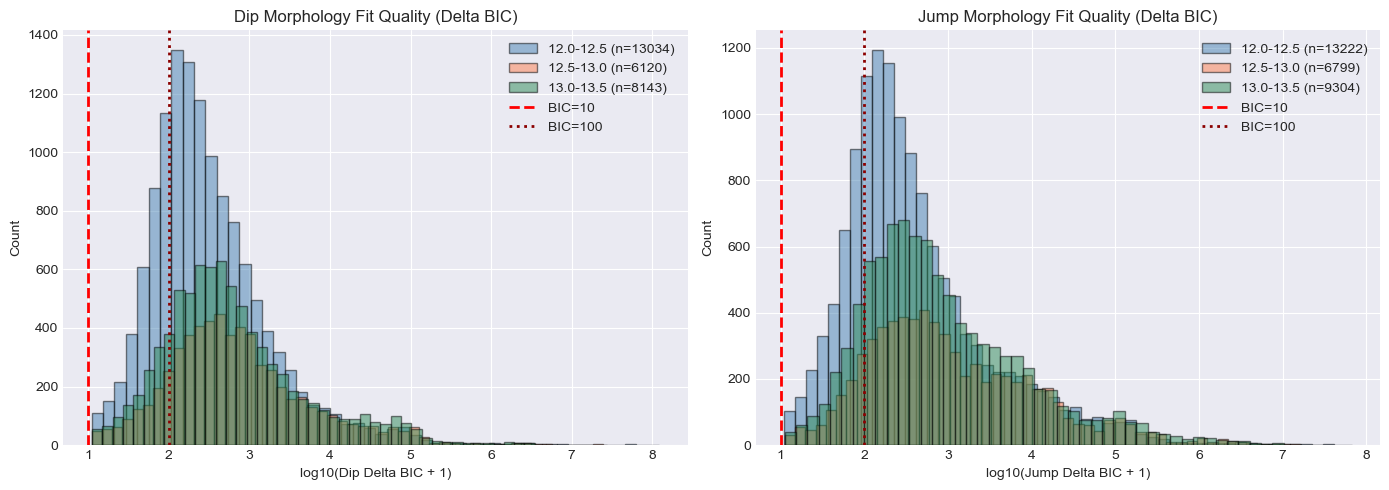

In [17]:
# Delta BIC distribution for morphological fits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define datasets for iteration
plot_datasets = [(df_bright, '12.0-12.5', 'steelblue'), (df_mid, '12.5-13.0', 'coral'), (df_faint, '13.0-13.5', 'seagreen')]

# Filter to non-zero BIC (has morphology fit)
for df, label, color in plot_datasets:
    bic = df[df['dip_best_delta_bic'] > 0]['dip_best_delta_bic']
    axes[0].hist(np.log10(bic + 1), bins=50, alpha=0.5, label=f'{label} (n={len(bic)})', edgecolor='black', color=color)
axes[0].axvline(np.log10(10), color='red', linestyle='--', lw=2, label='BIC=10')
axes[0].axvline(np.log10(100), color='darkred', linestyle=':', lw=2, label='BIC=100')
axes[0].set_xlabel('log10(Dip Delta BIC + 1)')
axes[0].set_ylabel('Count')
axes[0].set_title('Dip Morphology Fit Quality (Delta BIC)')
axes[0].legend()

for df, label, color in plot_datasets:
    bic = df[df['jump_best_delta_bic'] > 0]['jump_best_delta_bic']
    axes[1].hist(np.log10(bic + 1), bins=50, alpha=0.5, label=f'{label} (n={len(bic)})', edgecolor='black', color=color)
axes[1].axvline(np.log10(10), color='red', linestyle='--', lw=2, label='BIC=10')
axes[1].axvline(np.log10(100), color='darkred', linestyle=':', lw=2, label='BIC=100')
axes[1].set_xlabel('log10(Jump Delta BIC + 1)')
axes[1].set_ylabel('Count')
axes[1].set_title('Jump Morphology Fit Quality (Delta BIC)')
axes[1].legend()

plt.tight_layout()
plt.show()

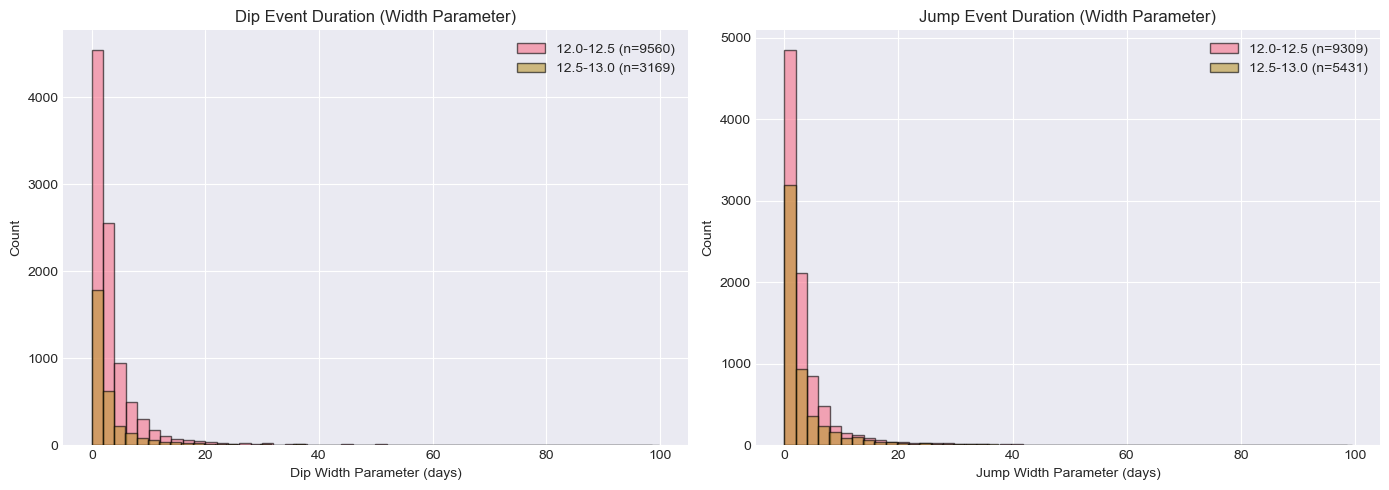

In [18]:
# Morphology width parameter (event duration proxy)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for df, label in [(df_bright, '12.0-12.5'), (df_faint, '12.5-13.0')]:
    width = df[(df['dip_best_morph'] != 'none') & (df['dip_best_width_param'] > 0)]['dip_best_width_param']
    width = width[width < 100]  # clip outliers
    if len(width) > 0:
        axes[0].hist(width, bins=50, alpha=0.6, label=f'{label} (n={len(width)})', edgecolor='black')
axes[0].set_xlabel('Dip Width Parameter (days)')
axes[0].set_ylabel('Count')
axes[0].set_title('Dip Event Duration (Width Parameter)')
axes[0].legend()

for df, label in [(df_bright, '12.0-12.5'), (df_faint, '12.5-13.0')]:
    width = df[(df['jump_best_morph'] != 'none') & (df['jump_best_width_param'] > 0)]['jump_best_width_param']
    width = width[width < 100]
    if len(width) > 0:
        axes[1].hist(width, bins=50, alpha=0.6, label=f'{label} (n={len(width)})', edgecolor='black')
axes[1].set_xlabel('Jump Width Parameter (days)')
axes[1].set_ylabel('Count')
axes[1].set_title('Jump Event Duration (Width Parameter)')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Dipper Score Analysis

The dipper score is a composite metric based on Tzanidakis+2025:
- Measures ingress vs egress asymmetry
- Higher scores indicate more asymmetric (dipper-like) events
- Eclipsing binaries are typically symmetric (low score)

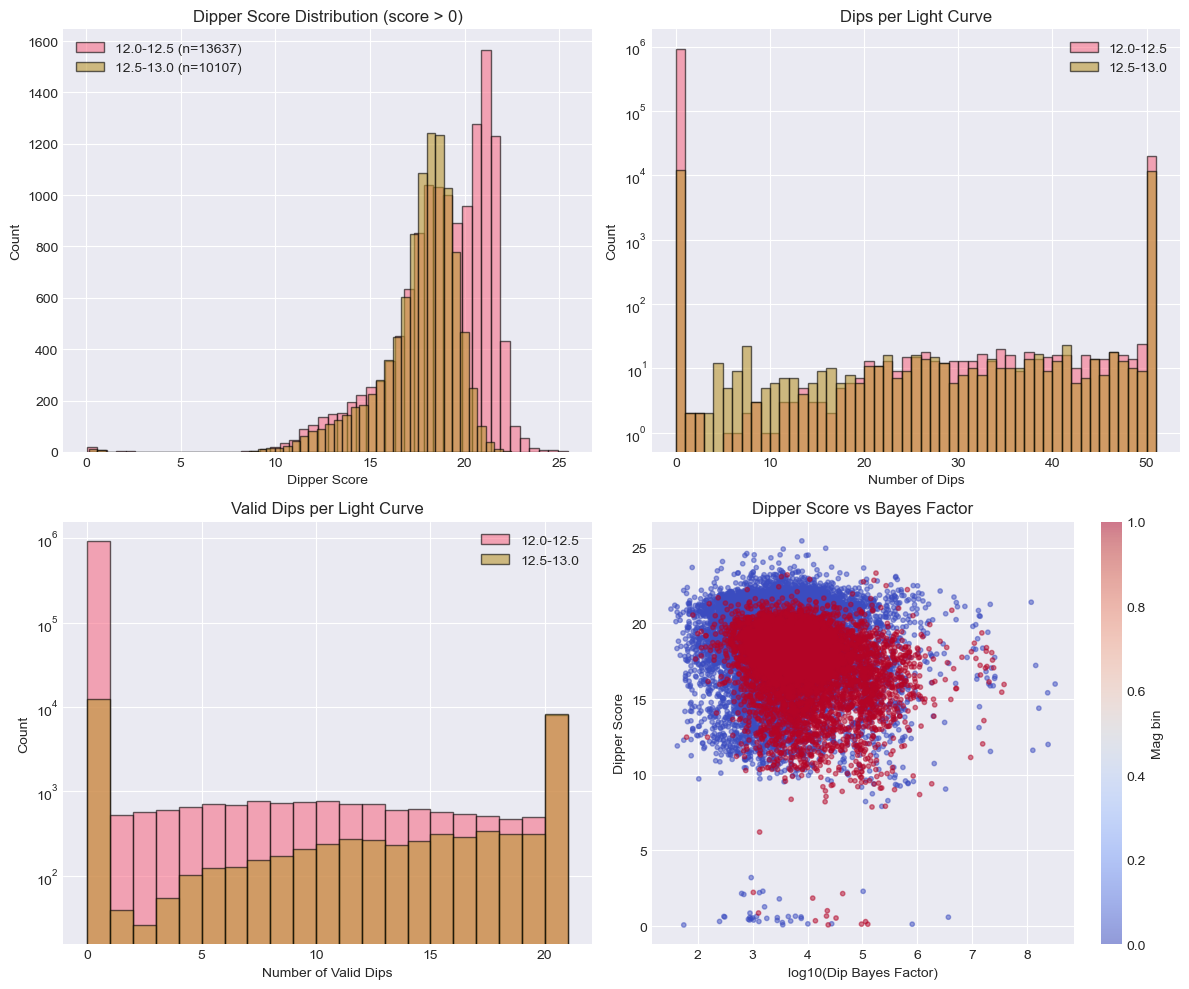

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Dipper score distribution (filter out inf/nan)
for df, label in [(df_bright, '12.0-12.5'), (df_faint, '12.5-13.0')]:
    score = df['dipper_score'][np.isfinite(df['dipper_score'])]
    score = score[score > 0]  # only positive scores
    if len(score) > 0:
        axes[0, 0].hist(score, bins=50, alpha=0.6, label=f'{label} (n={len(score)})', edgecolor='black')
axes[0, 0].set_xlabel('Dipper Score')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Dipper Score Distribution (score > 0)')
axes[0, 0].legend()

# Number of dips per light curve
for df, label in [(df_bright, '12.0-12.5'), (df_faint, '12.5-13.0')]:
    n_dips = df['dipper_n_dips'].clip(upper=50)
    axes[0, 1].hist(n_dips, bins=range(0, 52), alpha=0.6, label=label, edgecolor='black')
axes[0, 1].set_xlabel('Number of Dips')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Dips per Light Curve')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()

# Valid dips per light curve
for df, label in [(df_bright, '12.0-12.5'), (df_faint, '12.5-13.0')]:
    n_valid = df['dipper_n_valid_dips'].clip(upper=20)
    axes[1, 0].hist(n_valid, bins=range(0, 22), alpha=0.6, label=label, edgecolor='black')
axes[1, 0].set_xlabel('Number of Valid Dips')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Valid Dips per Light Curve')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()

# Dipper score vs Bayes Factor
df_valid = df_combined[(df_combined['dipper_score'] > 0) & np.isfinite(df_combined['dipper_score'])]
sc = axes[1, 1].scatter(
    np.log10(df_valid['dip_bayes_factor'].replace(0, 1)),
    df_valid['dipper_score'],
    c=df_valid['mag_bin'].map({'12.0-12.5': 0, '12.5-13.0': 1}),
    alpha=0.5, s=10, cmap='coolwarm'
)
axes[1, 1].set_xlabel('log10(Dip Bayes Factor)')
axes[1, 1].set_ylabel('Dipper Score')
axes[1, 1].set_title('Dipper Score vs Bayes Factor')
plt.colorbar(sc, ax=axes[1, 1], label='Mag bin')

plt.tight_layout()
plt.show()

## 8. Baseline Magnitude Analysis

The fitted baseline magnitude and event depths help characterize the detection sensitivity across magnitude bins.

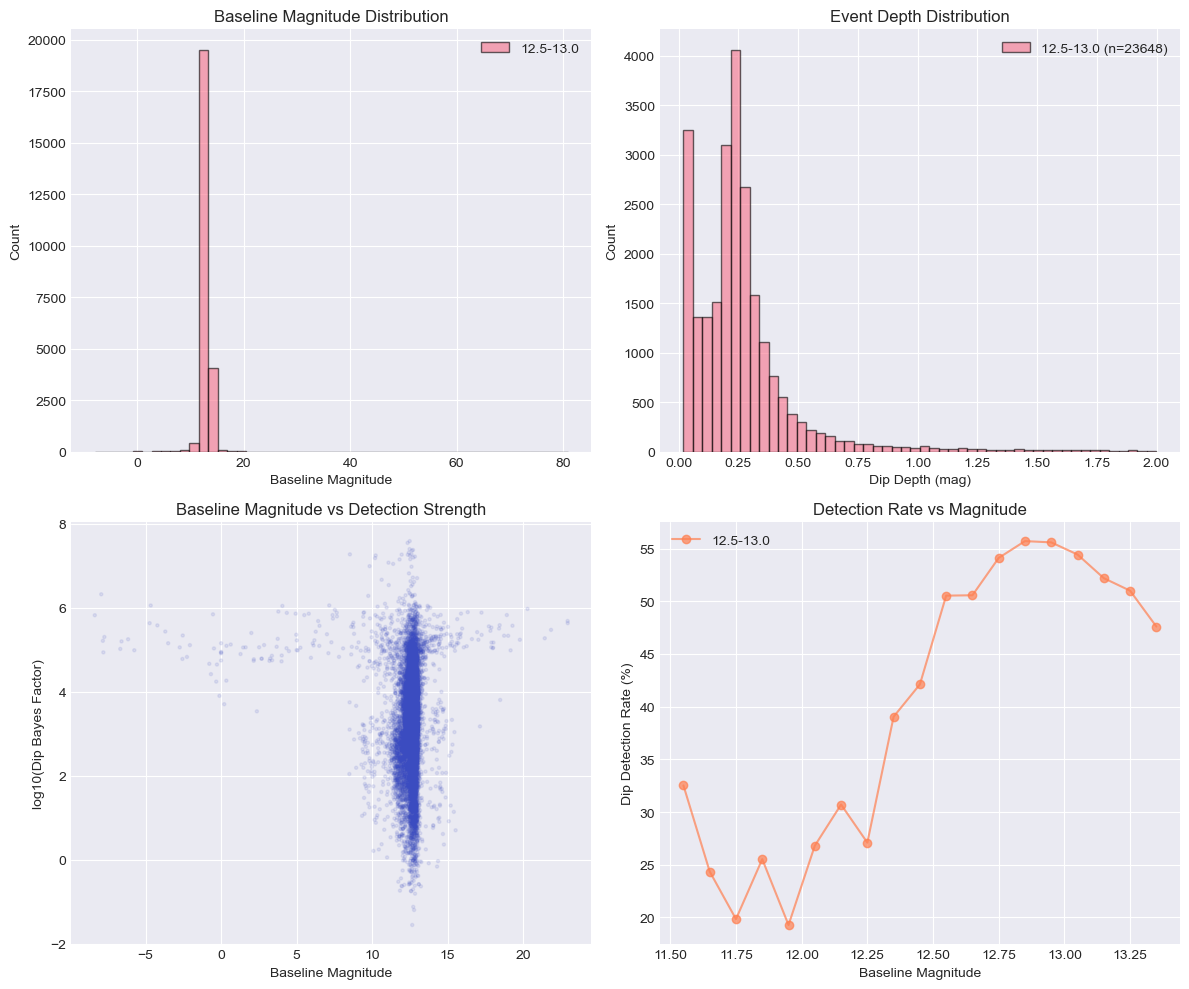

In [20]:
# Check if baseline_mag column exists in both
has_baseline = 'baseline_mag' in df_combined.columns

if has_baseline:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Baseline magnitude distribution
    for df, label in [(df_bright, '12.0-12.5'), (df_faint, '12.5-13.0')]:
        if 'baseline_mag' in df.columns:
            axes[0, 0].hist(df['baseline_mag'].dropna(), bins=50, alpha=0.6, label=label, edgecolor='black')
    axes[0, 0].set_xlabel('Baseline Magnitude')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Baseline Magnitude Distribution')
    axes[0, 0].legend()
    
    # Event depth (dip_best_mag_event - baseline_mag)
    for df, label in [(df_bright, '12.0-12.5'), (df_faint, '12.5-13.0')]:
        if 'baseline_mag' in df.columns and 'dip_best_mag_event' in df.columns:
            depth = df['dip_best_mag_event'] - df['baseline_mag']
            depth = depth[(depth > 0) & (depth < 2)]  # positive dip depths up to 2 mag
            if len(depth) > 0:
                axes[0, 1].hist(depth, bins=50, alpha=0.6, label=f'{label} (n={len(depth)})', edgecolor='black')
    axes[0, 1].set_xlabel('Dip Depth (mag)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Event Depth Distribution')
    axes[0, 1].legend()
    
    # Baseline vs Bayes Factor
    if 'baseline_mag' in df_combined.columns:
        axes[1, 0].scatter(
            df_combined['baseline_mag'],
            np.log10(df_combined['dip_bayes_factor'].replace(0, 1)),
            c=df_combined['mag_bin'].map({'12.0-12.5': 0, '12.5-13.0': 1}),
            alpha=0.1, s=5, cmap='coolwarm'
        )
    axes[1, 0].set_xlabel('Baseline Magnitude')
    axes[1, 0].set_ylabel('log10(Dip Bayes Factor)')
    axes[1, 0].set_title('Baseline Magnitude vs Detection Strength')
    
    # Detection rate by magnitude
    if 'baseline_mag' in df_combined.columns:
        mag_bins = np.arange(11.5, 13.5, 0.1)
        for df, label, color in [(df_bright, '12.0-12.5', 'steelblue'), (df_faint, '12.5-13.0', 'coral')]:
            if 'baseline_mag' in df.columns:
                df_temp = df.copy()
                df_temp['mag_binned'] = pd.cut(df_temp['baseline_mag'], bins=mag_bins)
                det_rate = df_temp.groupby('mag_binned')['dip_significant'].mean() * 100
                centers = [(b.left + b.right) / 2 for b in det_rate.index]
                axes[1, 1].plot(centers, det_rate.values, 'o-', label=label, color=color, alpha=0.7)
        axes[1, 1].set_xlabel('Baseline Magnitude')
        axes[1, 1].set_ylabel('Dip Detection Rate (%)')
        axes[1, 1].set_title('Detection Rate vs Magnitude')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("baseline_mag column not found in one or both datasets")
    print(f"Bright columns: {'baseline_mag' in df_bright.columns}")
    print(f"Faint columns: {'baseline_mag' in df_faint.columns}")

## 9. Filter Performance Analysis

Analysis of how different filtering thresholds affect the candidate pool.

### Standard Thresholds (from MALCA pipeline):
- Bayes Factor > 10-20
- Event probability > 0.5-0.99
- Run count >= 1
- Run points >= 2
- Run cameras >= 2 (multi-camera confirmation)

In [21]:
print("=== Filter Threshold Analysis ===")
print()

for df, label in [(df_bright, 'Bright (12.0-12.5)'), (df_mid, 'Mid (12.5-13.0)'), (df_faint, 'Faint (13.0-13.5)')]:
    print(f"\n{'='*60}")
    print(f"{label}: {len(df):,} total light curves")
    print(f"{'='*60}")
    
    print("\nBayes Factor Thresholds (dip OR jump):")
    for thresh in [1, 3, 10, 30, 100, 1000]:
        n = ((df['dip_bayes_factor'] > thresh) | (df['jump_bayes_factor'] > thresh)).sum()
        print(f"  BF > {thresh:>5}: {n:>8,} ({n/len(df)*100:5.2f}%)")
    
    print("\nEvent Probability Thresholds (dip OR jump):")
    for thresh in [0.5, 0.9, 0.99, 0.999, 0.9999]:
        n = ((df['dip_max_event_prob'] > thresh) | (df['jump_max_event_prob'] > thresh)).sum()
        print(f"  P > {thresh:.4f}: {n:>8,} ({n/len(df)*100:5.2f}%)")
    
    print("\nRun Requirements (dip OR jump):")
    for min_runs in [1, 2, 3, 5]:
        n = ((df['dip_run_count'] >= min_runs) | (df['jump_run_count'] >= min_runs)).sum()
        print(f"  Runs >= {min_runs}: {n:>8,} ({n/len(df)*100:5.2f}%)")
    
    print("\nMulti-Camera Requirement (dip OR jump):")
    for min_cams in [1, 2, 3, 4]:
        n = ((df['dip_max_run_cameras'] >= min_cams) | (df['jump_max_run_cameras'] >= min_cams)).sum()
        print(f"  Run cams >= {min_cams}: {n:>8,} ({n/len(df)*100:5.2f}%)")

=== Filter Threshold Analysis ===


Bright (12.0-12.5): 950,519 total light curves

Bayes Factor Thresholds (dip OR jump):
  BF >     1:  916,563 (96.43%)
  BF >     3:  890,930 (93.73%)
  BF >    10:  787,124 (82.81%)
  BF >    30:  486,686 (51.20%)
  BF >   100:  141,803 (14.92%)
  BF >  1000:   23,177 ( 2.44%)

Event Probability Thresholds (dip OR jump):
  P > 0.5000:  930,041 (97.85%)
  P > 0.9000:  895,155 (94.18%)
  P > 0.9900:  810,615 (85.28%)
  P > 0.9990:  688,163 (72.40%)
  P > 0.9999:  566,391 (59.59%)

Run Requirements (dip OR jump):
  Runs >= 1:   27,610 ( 2.90%)
  Runs >= 2:   16,904 ( 1.78%)
  Runs >= 3:   12,918 ( 1.36%)
  Runs >= 5:    8,120 ( 0.85%)

Multi-Camera Requirement (dip OR jump):
  Run cams >= 1:   27,610 ( 2.90%)
  Run cams >= 2:    7,198 ( 0.76%)
  Run cams >= 3:    1,177 ( 0.12%)
  Run cams >= 4:      264 ( 0.03%)

Mid (12.5-13.0): 16,692 total light curves

Bayes Factor Thresholds (dip OR jump):
  BF >     1:   15,678 (93.93%)
  BF >     3:   15,572 (93

In [22]:
print("=== Combined Filtering Scenarios (Progressive) ===")
print()

for df, label in [(df_bright, 'Bright (12.0-12.5)'), (df_mid, 'Mid (12.5-13.0)'), (df_faint, 'Faint (13.0-13.5)'), (df_combined, 'Combined')]:
    print(f"\n{label}: {len(df):,} total")
    print("-" * 50)
    
    # Progressive filtering for DIPS specifically
    n = len(df)
    
    # Start with Bayes Factor threshold
    mask1 = df['dip_bayes_factor'] > 10
    
    # Add event probability
    mask2 = mask1 & (df['dip_max_event_prob'] > 0.5)
    
    # Add run requirement
    mask3 = mask2 & (df['dip_run_count'] >= 1)
    
    # Add multi-point runs
    mask4 = mask3 & (df['dip_max_run_points'] >= 2)
    
    # Add multi-camera runs (CRITICAL for ruling out artifacts)
    mask5 = mask4 & (df['dip_max_run_cameras'] >= 2)
    
    # Add morphology requirement
    mask6 = mask5 & (df['dip_best_morph'].isin(['gaussian', 'skew_gaussian']))
    
    # Add BIC threshold
    mask7 = mask6 & (df['dip_best_delta_bic'] > 10)
    
    scenarios = [
        ("1. BF > 10", mask1),
        ("2. + Prob > 0.5", mask2),
        ("3. + Run count >= 1", mask3),
        ("4. + Run points >= 2", mask4),
        ("5. + Run cameras >= 2", mask5),
        ("6. + Morph = gauss/skew", mask6),
        ("7. + Delta BIC > 10", mask7),
    ]
    
    for desc, mask in scenarios:
        n_pass = mask.sum()
        print(f"  {desc:25s}: {n_pass:>7,} ({n_pass/n*100:5.2f}%)")

=== Combined Filtering Scenarios (Progressive) ===


Bright (12.0-12.5): 950,519 total
--------------------------------------------------
  1. BF > 10               : 654,444 (68.85%)
  2. + Prob > 0.5          : 654,444 (68.85%)
  3. + Run count >= 1      :  20,315 ( 2.14%)
  4. + Run points >= 2     :  20,315 ( 2.14%)
  5. + Run cameras >= 2    :   4,792 ( 0.50%)
  6. + Morph = gauss/skew  :   3,109 ( 0.33%)
  7. + Delta BIC > 10      :   3,109 ( 0.33%)

Mid (12.5-13.0): 16,692 total
--------------------------------------------------
  1. BF > 10               :  14,742 (88.32%)
  2. + Prob > 0.5          :  14,742 (88.32%)
  3. + Run count >= 1      :   9,085 (54.43%)
  4. + Run points >= 2     :   9,085 (54.43%)
  5. + Run cameras >= 2    :   2,613 (15.65%)
  6. + Morph = gauss/skew  :   1,852 (11.10%)
  7. + Delta BIC > 10      :   1,852 (11.10%)

Faint (13.0-13.5): 24,295 total
--------------------------------------------------
  1. BF > 10               :  20,955 (86.25%)
  2. +

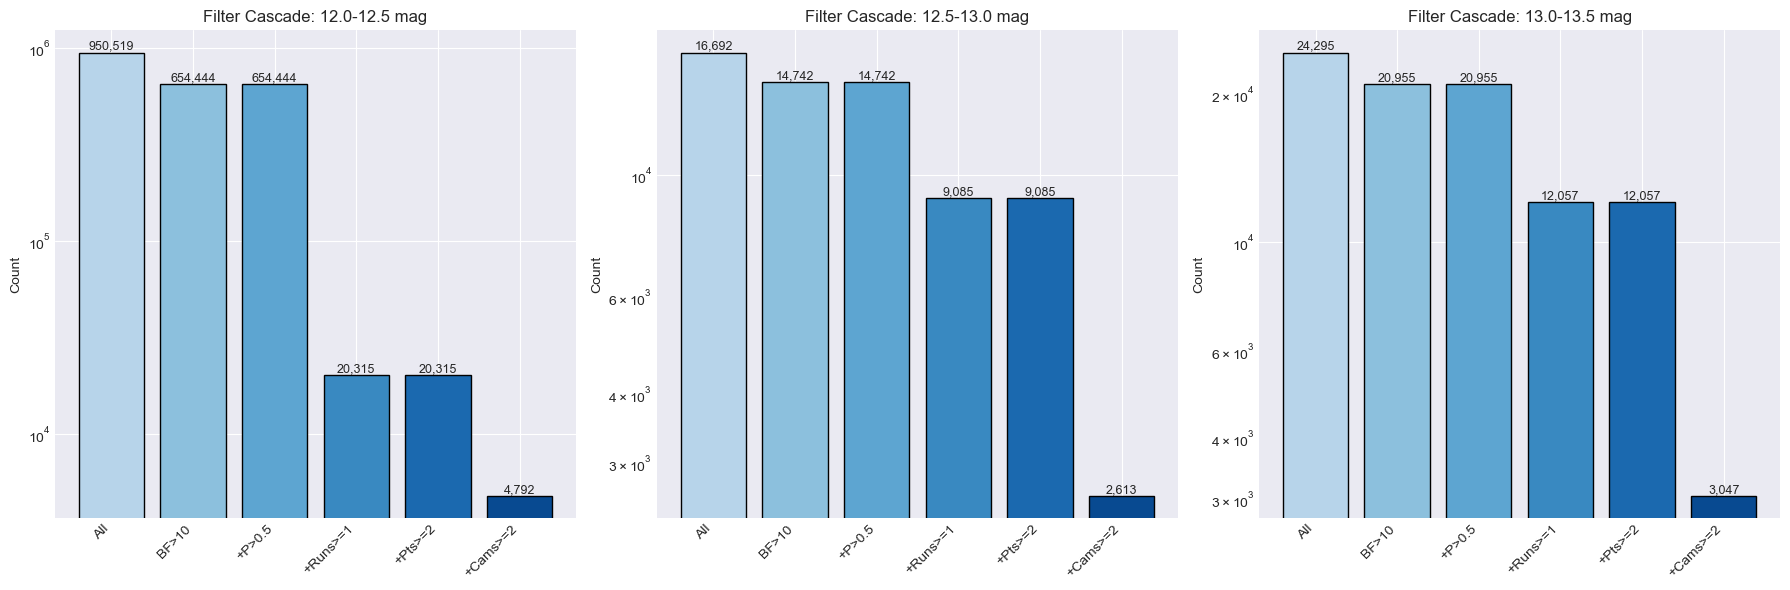

In [23]:
# Visualize filter cascade
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (df, label) in zip(axes, [(df_bright, '12.0-12.5'), (df_mid, '12.5-13.0'), (df_faint, '13.0-13.5')]):
    n = len(df)
    
    filters = [
        ('All', n),
        ('BF>10', (df['dip_bayes_factor'] > 10).sum()),
        ('+P>0.5', ((df['dip_bayes_factor'] > 10) & (df['dip_max_event_prob'] > 0.5)).sum()),
        ('+Runs>=1', ((df['dip_bayes_factor'] > 10) & (df['dip_run_count'] >= 1)).sum()),
        ('+Pts>=2', ((df['dip_bayes_factor'] > 10) & (df['dip_run_count'] >= 1) & (df['dip_max_run_points'] >= 2)).sum()),
        ('+Cams>=2', ((df['dip_bayes_factor'] > 10) & (df['dip_run_count'] >= 1) & (df['dip_max_run_points'] >= 2) & (df['dip_max_run_cameras'] >= 2)).sum()),
    ]
    
    labels, counts = zip(*filters)
    bars = ax.bar(range(len(labels)), counts, color=plt.cm.Blues(np.linspace(0.3, 0.9, len(labels))), edgecolor='black')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Count')
    ax.set_title(f'Filter Cascade: {label} mag')
    ax.set_yscale('log')
    
    # Add count labels
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}', 
                ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

## 10. Correlation Analysis

Understanding relationships between detection metrics helps identify:
- Redundant filters
- Key predictors of real events
- Potential biases

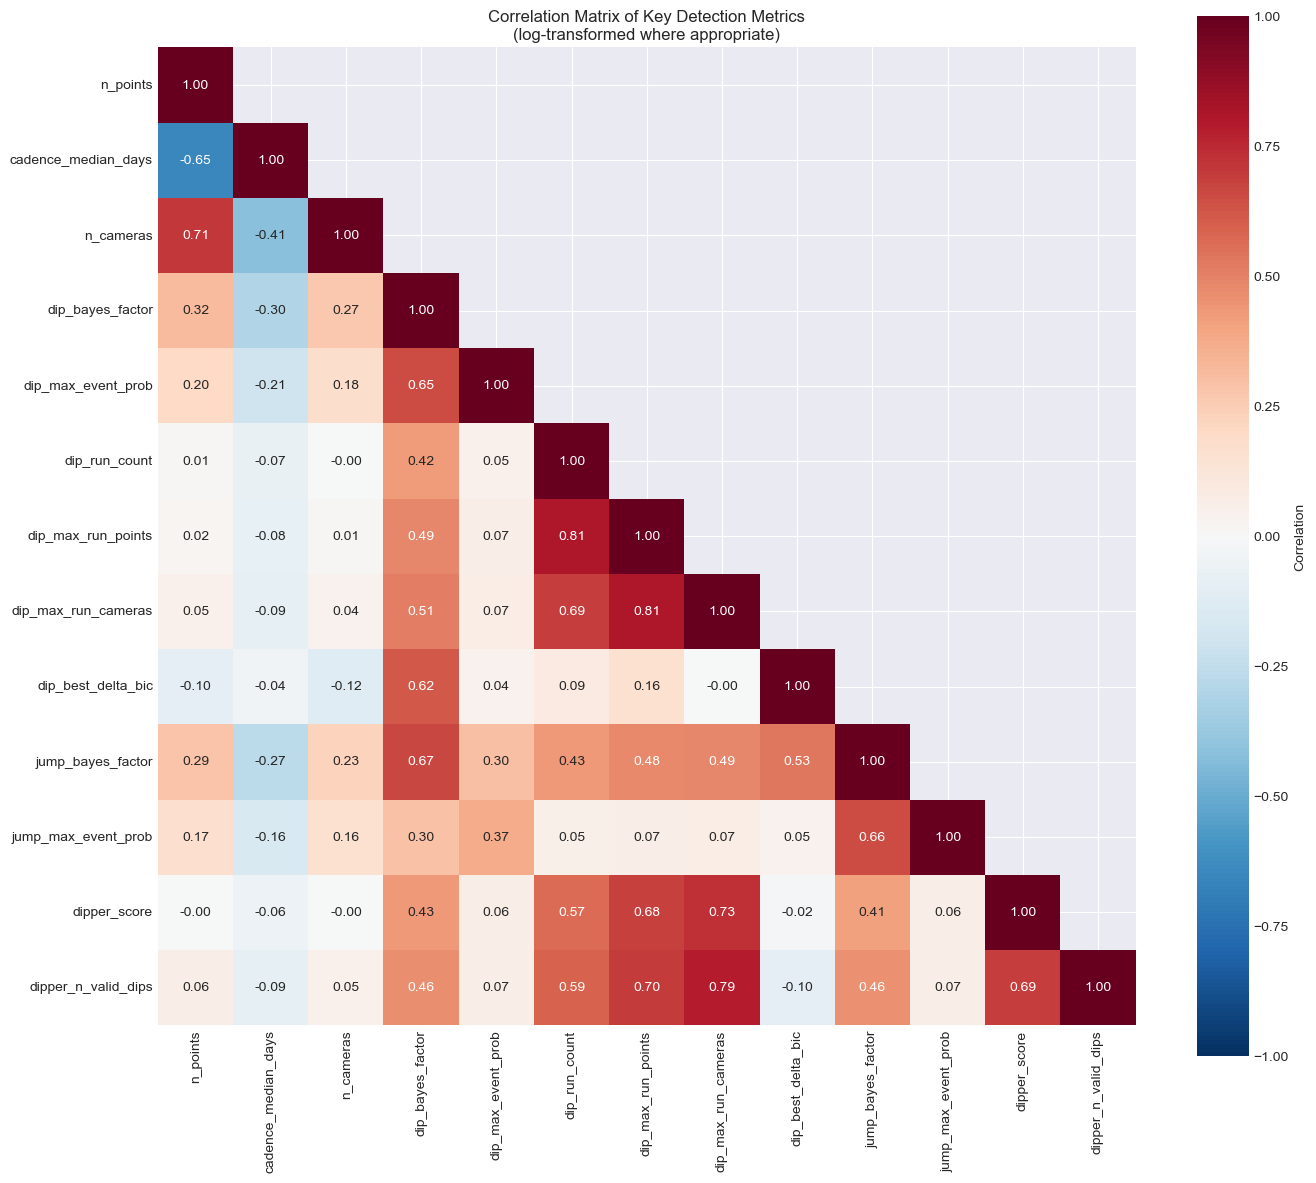

In [24]:
# Key metrics for correlation analysis
corr_cols = [
    'n_points', 'cadence_median_days', 'n_cameras',
    'dip_bayes_factor', 'dip_max_event_prob', 
    'dip_run_count', 'dip_max_run_points', 'dip_max_run_cameras',
    'dip_best_delta_bic',
    'jump_bayes_factor', 'jump_max_event_prob',
    'dipper_score', 'dipper_n_valid_dips'
]

# Filter to columns that exist in both datasets
corr_cols = [c for c in corr_cols if c in df_combined.columns]

# Log-transform some columns for better correlation visualization
df_corr = df_combined[corr_cols].copy()
for col in ['dip_bayes_factor', 'jump_bayes_factor', 'dip_best_delta_bic']:
    if col in df_corr.columns:
        df_corr[col] = np.log10(df_corr[col].replace(0, np.nan) + 1)

# Handle infinite values in dipper_score
if 'dipper_score' in df_corr.columns:
    df_corr['dipper_score'] = df_corr['dipper_score'].replace([np.inf, -np.inf], np.nan)

corr = df_corr.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            square=True, mask=mask, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix of Key Detection Metrics\n(log-transformed where appropriate)')
plt.tight_layout()
plt.show()

## 11. Strong Candidate Identification

Identifying the most promising disk occultation candidates using combined filtering criteria.

In [25]:
def identify_candidates(df, label, 
                        bf_thresh=10, 
                        prob_thresh=0.5, 
                        min_runs=1, 
                        min_run_pts=2, 
                        min_run_cams=2,
                        require_morph=True,
                        min_bic=10):
    """
    Identify strong dip candidates based on multiple criteria.
    Returns DataFrame of candidates and summary statistics.
    """
    mask = (
        (df['dip_bayes_factor'] > bf_thresh) &
        (df['dip_max_event_prob'] > prob_thresh) &
        (df['dip_run_count'] >= min_runs) &
        (df['dip_max_run_points'] >= min_run_pts) &
        (df['dip_max_run_cameras'] >= min_run_cams)
    )
    
    if require_morph:
        mask = mask & (df['dip_best_morph'].isin(['gaussian', 'skew_gaussian']))
        mask = mask & (df['dip_best_delta_bic'] > min_bic)
    
    candidates = df[mask].copy()
    
    print(f"\n{label}:")
    print(f"  Total light curves: {len(df):,}")
    print(f"  Strong candidates:  {len(candidates):,} ({len(candidates)/len(df)*100:.3f}%)")
    
    if len(candidates) > 0:
        print(f"\n  Morphology breakdown:")
        for morph, count in candidates['dip_best_morph'].value_counts().items():
            print(f"    {morph}: {count}")
    
    return candidates

# Identify candidates in each sample
candidates_bright = identify_candidates(df_bright, "Bright Sample (12.0-12.5 mag)")
candidates_faint = identify_candidates(df_faint, "Faint Sample (12.5-13.0 mag)")
candidates_all = identify_candidates(df_combined, "Combined")


Bright Sample (12.0-12.5 mag):
  Total light curves: 950,519
  Strong candidates:  3,109 (0.327%)

  Morphology breakdown:
    gaussian: 3109

Faint Sample (12.5-13.0 mag):
  Total light curves: 24,295
  Strong candidates:  2,120 (8.726%)

  Morphology breakdown:
    gaussian: 1216
    skew_gaussian: 904

Combined:
  Total light curves: 991,506
  Strong candidates:  7,081 (0.714%)

  Morphology breakdown:
    gaussian: 5409
    skew_gaussian: 1672


In [26]:
# Top candidates by Bayes Factor
display_cols = [
    'path', 'mag_bin',
    'dip_bayes_factor', 'dip_max_event_prob',
    'dip_run_count', 'dip_max_run_points', 'dip_max_run_cameras',
    'dip_best_morph', 'dip_best_delta_bic', 'dip_best_width_param',
    'n_points', 'n_cameras', 'dipper_score'
]

# Filter to columns that exist
display_cols = [c for c in display_cols if c in candidates_all.columns]

if len(candidates_all) > 0:
    print("=== Top 20 Candidates by Bayes Factor ===")
    top20 = candidates_all.nlargest(20, 'dip_bayes_factor')[display_cols]
    print(top20.to_string())
else:
    print("No candidates found with the specified criteria")

=== Top 20 Candidates by Bayes Factor ===
                                                                              path    mag_bin  dip_bayes_factor  dip_max_event_prob  dip_run_count  dip_max_run_points  dip_max_run_cameras dip_best_morph  dip_best_delta_bic  dip_best_width_param  n_points  n_cameras  dipper_score
732725  /data/poohbah/1/assassin/rowan.90/lcsv2/12_12.5/lc10_cal/575525737916.dat2  12.0-12.5      1.197166e+08                 1.0              7                   9                    2       gaussian        1.345650e+02              0.285286      1946          8     21.396845
666765   /data/poohbah/1/assassin/rowan.90/lcsv2/12_12.5/lc2_cal/523986722222.dat2  12.0-12.5      4.771185e+07                 1.0              3                   3                    2       gaussian        1.991021e+06              0.692910      2321         10     -4.460474
667180   /data/poohbah/1/assassin/rowan.90/lcsv2/12_12.5/lc7_cal/523986766547.dat2  12.0-12.5      3.993224e+07       

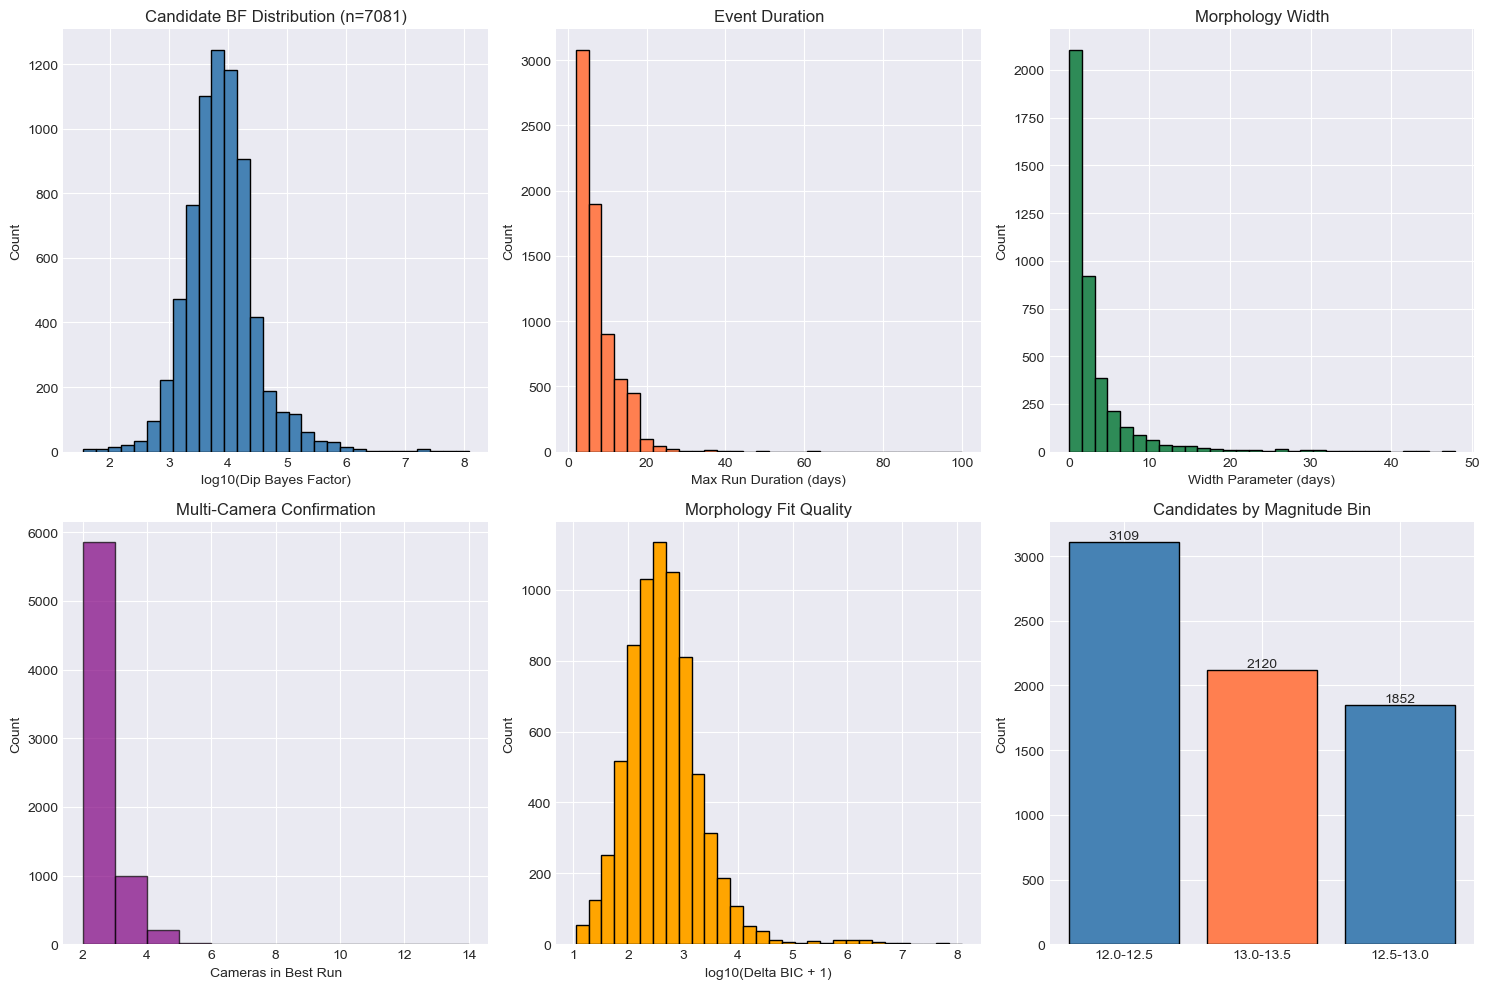

In [27]:
# Candidate property distributions
if len(candidates_all) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Bayes Factor distribution
    axes[0, 0].hist(np.log10(candidates_all['dip_bayes_factor']), bins=30, edgecolor='black', color='steelblue')
    axes[0, 0].set_xlabel('log10(Dip Bayes Factor)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title(f'Candidate BF Distribution (n={len(candidates_all)})')
    
    # Run duration
    duration = candidates_all['dip_max_run_duration'].dropna()
    if len(duration) > 0:
        axes[0, 1].hist(duration.clip(upper=100), bins=30, edgecolor='black', color='coral')
    axes[0, 1].set_xlabel('Max Run Duration (days)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Event Duration')
    
    # Width parameter
    width = candidates_all['dip_best_width_param'].dropna()
    width = width[(width > 0) & (width < 50)]
    if len(width) > 0:
        axes[0, 2].hist(width, bins=30, edgecolor='black', color='seagreen')
    axes[0, 2].set_xlabel('Width Parameter (days)')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Morphology Width')
    
    # Cameras in run
    axes[1, 0].hist(candidates_all['dip_max_run_cameras'], bins=range(2, 15), edgecolor='black', color='purple', alpha=0.7)
    axes[1, 0].set_xlabel('Cameras in Best Run')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Multi-Camera Confirmation')
    
    # Delta BIC
    bic = candidates_all['dip_best_delta_bic']
    axes[1, 1].hist(np.log10(bic + 1), bins=30, edgecolor='black', color='orange')
    axes[1, 1].set_xlabel('log10(Delta BIC + 1)')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Morphology Fit Quality')
    
    # By magnitude bin
    mag_counts = candidates_all['mag_bin'].value_counts()
    bars = axes[1, 2].bar(range(len(mag_counts)), mag_counts.values, 
                          tick_label=mag_counts.index, color=['steelblue', 'coral'], edgecolor='black')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('Candidates by Magnitude Bin')
    for bar, count in zip(bars, mag_counts.values):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count}', 
                        ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("No candidates to visualize")

## 12. Magnitude Bin Comparison Summary

Systematic comparison of detection characteristics between the two magnitude bins.

In [28]:
def compute_summary_stats(df, label):
    """Compute comprehensive summary statistics for a dataset."""
    n = len(df)
    
    stats = {
        'Label': label,
        'Total LCs': n,
        'Dip detections': df['dip_significant'].sum(),
        'Dip rate (%)': df['dip_significant'].sum() / n * 100,
        'Jump detections': df['jump_significant'].sum(),
        'Jump rate (%)': df['jump_significant'].sum() / n * 100,
        'Median n_points': df['n_points'].median(),
        'Median n_cameras': df['n_cameras'].median(),
        'Median cadence (days)': df['cadence_median_days'].median(),
        'Has dip run (%)': (df['dip_run_count'] >= 1).sum() / n * 100,
        'Multi-cam dip run (%)': (df['dip_max_run_cameras'] >= 2).sum() / n * 100,
        'Gaussian dips': (df['dip_best_morph'] == 'gaussian').sum(),
        'Skew-Gaussian dips': (df['dip_best_morph'] == 'skew_gaussian').sum(),
    }
    
    return stats

# Compute stats for all samples
stats_bright_full = compute_summary_stats(df_bright, '12.0-12.5 mag')
stats_mid_full = compute_summary_stats(df_mid, '12.5-13.0 mag')
stats_faint_full = compute_summary_stats(df_faint, '13.0-13.5 mag')

# Create comparison DataFrame
comparison_df = pd.DataFrame([stats_bright_full, stats_mid_full, stats_faint_full])
comparison_df = comparison_df.set_index('Label').T

print("=== Magnitude Bin Comparison ===")
print(comparison_df.to_string())

=== Magnitude Bin Comparison ===
Label                  12.0-12.5 mag  12.5-13.0 mag  13.0-13.5 mag
Total LCs              950519.000000   16692.000000   24295.000000
Dip detections          20315.000000    9085.000000   12057.000000
Dip rate (%)                2.137253      54.427271      49.627495
Jump detections         17614.000000    8426.000000   11408.000000
Jump rate (%)               1.853093      50.479272      46.956164
Median n_points          1176.000000    1178.000000    1174.000000
Median n_cameras            6.000000       6.000000       6.000000
Median cadence (days)       1.201325       1.091197       1.092521
Has dip run (%)             2.137253      54.427271      49.627495
Multi-cam dip run (%)       0.504146      15.654206      12.541675
Gaussian dips           13034.000000    3646.000000    4755.000000
Skew-Gaussian dips          0.000000    2474.000000    3388.000000


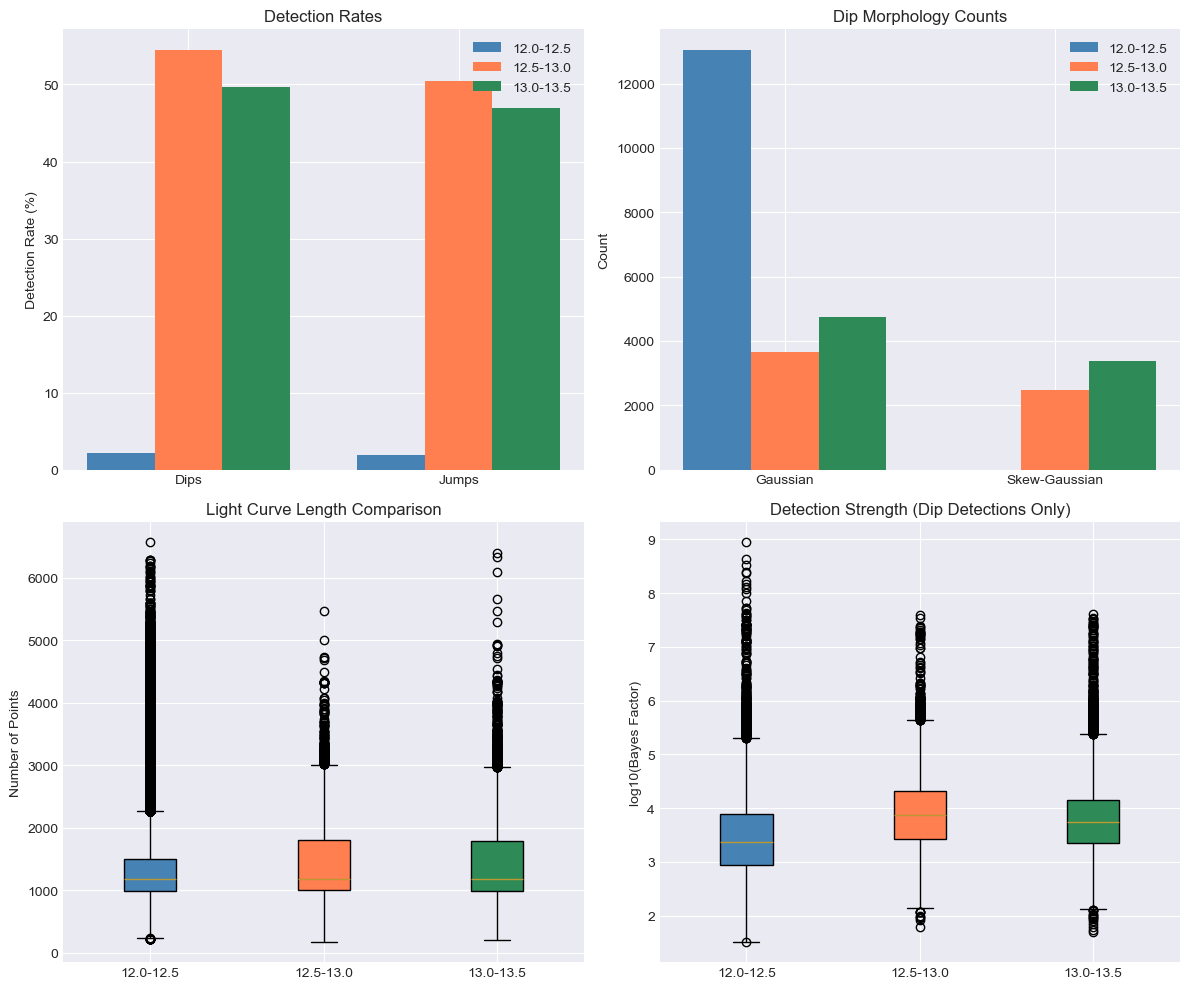

In [29]:
# Visual comparison of key metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Detection rates
rates_bright = [stats_bright_full['Dip rate (%)'], stats_bright_full['Jump rate (%)']]
rates_mid = [stats_mid_full['Dip rate (%)'], stats_mid_full['Jump rate (%)']]
rates_faint = [stats_faint_full['Dip rate (%)'], stats_faint_full['Jump rate (%)']]

x = np.arange(2)
width = 0.25
axes[0, 0].bar(x - width, rates_bright, width, label='12.0-12.5', color='steelblue')
axes[0, 0].bar(x, rates_mid, width, label='12.5-13.0', color='coral')
axes[0, 0].bar(x + width, rates_faint, width, label='13.0-13.5', color='seagreen')
axes[0, 0].set_ylabel('Detection Rate (%)')
axes[0, 0].set_title('Detection Rates')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(['Dips', 'Jumps'])
axes[0, 0].legend()

# Morphology comparison
morph_bright = [stats_bright_full['Gaussian dips'], stats_bright_full['Skew-Gaussian dips']]
morph_mid = [stats_mid_full['Gaussian dips'], stats_mid_full['Skew-Gaussian dips']]
morph_faint = [stats_faint_full['Gaussian dips'], stats_faint_full['Skew-Gaussian dips']]

axes[0, 1].bar(x - width, morph_bright, width, label='12.0-12.5', color='steelblue')
axes[0, 1].bar(x, morph_mid, width, label='12.5-13.0', color='coral')
axes[0, 1].bar(x + width, morph_faint, width, label='13.0-13.5', color='seagreen')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Dip Morphology Counts')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(['Gaussian', 'Skew-Gaussian'])
axes[0, 1].legend()

# Quality comparison (boxplots)
data_points = [df_bright['n_points'], df_mid['n_points'], df_faint['n_points']]
labels = ['12.0-12.5', '12.5-13.0', '13.0-13.5']
colors = ['steelblue', 'coral', 'seagreen']

bp1 = axes[1, 0].boxplot(data_points, labels=labels, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 0].set_ylabel('Number of Points')
axes[1, 0].set_title('Light Curve Length Comparison')

# Bayes Factor comparison (for detections)
bf_bright = df_bright[df_bright['dip_significant']]['dip_bayes_factor']
bf_mid = df_mid[df_mid['dip_significant']]['dip_bayes_factor']
bf_faint = df_faint[df_faint['dip_significant']]['dip_bayes_factor']

bf_data = []
bf_labels = []
bf_colors = []

if len(bf_bright) > 0: bf_data.append(np.log10(bf_bright)); bf_labels.append('12.0-12.5'); bf_colors.append('steelblue')
if len(bf_mid) > 0: bf_data.append(np.log10(bf_mid)); bf_labels.append('12.5-13.0'); bf_colors.append('coral')
if len(bf_faint) > 0: bf_data.append(np.log10(bf_faint)); bf_labels.append('13.0-13.5'); bf_colors.append('seagreen')

if bf_data:
    bp2 = axes[1, 1].boxplot(bf_data, labels=bf_labels, patch_artist=True)
    for patch, color in zip(bp2['boxes'], bf_colors):
        patch.set_facecolor(color)
    axes[1, 1].set_ylabel('log10(Bayes Factor)')
    axes[1, 1].set_title('Detection Strength (Dip Detections Only)')
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient detections', ha='center', va='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

## 13. Export Strong Candidates

In [30]:
# Export candidates with relaxed and strict criteria

# Relaxed: multi-camera dip runs
candidates_relaxed = df_combined[
    (df_combined['dip_run_count'] >= 1) &
    (df_combined['dip_max_run_cameras'] >= 2) &
    (df_combined['dip_max_run_points'] >= 2)
].copy()

# Strict: add morphology and BIC requirements
candidates_strict = df_combined[
    (df_combined['dip_bayes_factor'] > 10) &
    (df_combined['dip_run_count'] >= 1) &
    (df_combined['dip_max_run_cameras'] >= 2) &
    (df_combined['dip_max_run_points'] >= 2) &
    (df_combined['dip_best_morph'].isin(['gaussian', 'skew_gaussian'])) &
    (df_combined['dip_best_delta_bic'] > 10)
].copy()

print(f"Relaxed candidates (multi-cam runs): {len(candidates_relaxed):,}")
print(f"Strict candidates (+ morph + BIC):   {len(candidates_strict):,}")

# Save to files
relaxed_path = base_path / 'candidates_relaxed_combined.csv'
strict_path = base_path / 'candidates_strict_combined.csv'

candidates_relaxed.to_csv(relaxed_path, index=False)
candidates_strict.to_csv(strict_path, index=False)

print(f"\nSaved relaxed candidates to: {relaxed_path}")
print(f"Saved strict candidates to:  {strict_path}")

Relaxed candidates (multi-cam runs): 10,452
Strict candidates (+ morph + BIC):   7,081

Saved relaxed candidates to: /Users/calder/code/malca/output/candidates_relaxed_combined.csv
Saved strict candidates to:  /Users/calder/code/malca/output/candidates_strict_combined.csv


## 14. Summary & Key Findings

In [31]:
print("="*70)
print("COMPREHENSIVE EDA SUMMARY")
print("="*70)

print(f"""
DATASET OVERVIEW:
  Bright sample (12.0-12.5 mag): {len(df_bright):>10,} light curves
  Mid sample (12.5-13.0 mag):    {len(df_mid):>10,} light curves
  Faint sample (13.0-13.5 mag):  {len(df_faint):>10,} light curves
  Combined:                      {len(df_combined):>10,} light curves

DETECTION SUMMARY:
  Bright - Dip detections:  {df_bright['dip_significant'].sum():>6,} ({df_bright['dip_significant'].mean()*100:.2f}%)
  Bright - Jump detections: {df_bright['jump_significant'].sum():>6,} ({df_bright['jump_significant'].mean()*100:.2f}%)
  Mid    - Dip detections:  {df_mid['dip_significant'].sum():>6,} ({df_mid['dip_significant'].mean()*100:.2f}%)
  Mid    - Jump detections: {df_mid['jump_significant'].sum():>6,} ({df_mid['jump_significant'].mean()*100:.2f}%)
  Faint  - Dip detections:  {df_faint['dip_significant'].sum():>6,} ({df_faint['dip_significant'].mean()*100:.2f}%)
  Faint  - Jump detections: {df_faint['jump_significant'].sum():>6,} ({df_faint['jump_significant'].mean()*100:.2f}%)

MULTI-CAMERA ROBUST DETECTIONS (anti-artifact filter):
  Bright - Multi-cam dip runs (cams>=2): {((df_bright['dip_run_count'] >= 1) & (df_bright['dip_max_run_cameras'] >= 2)).sum():>6,}
  Mid    - Multi-cam dip runs (cams>=2): {((df_mid['dip_run_count'] >= 1) & (df_mid['dip_max_run_cameras'] >= 2)).sum():>6,}
  Faint  - Multi-cam dip runs (cams>=2): {((df_faint['dip_run_count'] >= 1) & (df_faint['dip_max_run_cameras'] >= 2)).sum():>6,}

MORPHOLOGY BREAKDOWN (Dips):
  Bright - Gaussian:      {(df_bright['dip_best_morph'] == 'gaussian').sum():>6,}
  Bright - Skew-Gaussian: {(df_bright['dip_best_morph'] == 'skew_gaussian').sum():>6,}
  Mid    - Gaussian:      {(df_mid['dip_best_morph'] == 'gaussian').sum():>6,}
  Mid    - Skew-Gaussian: {(df_mid['dip_best_morph'] == 'skew_gaussian').sum():>6,}
  Faint  - Gaussian:      {(df_faint['dip_best_morph'] == 'gaussian').sum():>6,}
  Faint  - Skew-Gaussian: {(df_faint['dip_best_morph'] == 'skew_gaussian').sum():>6,}

STRONG CANDIDATES (all criteria):
  Relaxed (multi-cam runs):     {len(candidates_relaxed):>6,}
  Strict (+ morph + BIC > 10):  {len(candidates_strict):>6,}
""")

print("\nKEY OBSERVATIONS:")
print("-" * 50)

# Compare detection rates across all three bins
rate_bright = df_bright['dip_significant'].mean() * 100
rate_mid = df_mid['dip_significant'].mean() * 100
rate_faint = df_faint['dip_significant'].mean() * 100
print(f"  - Dip detection rates: Bright={rate_bright:.2f}%, Mid={rate_mid:.2f}%, Faint={rate_faint:.2f}%")

# Multi-camera importance
multi_cam_frac = ((df_combined['dip_run_count'] >= 1) & (df_combined['dip_max_run_cameras'] >= 2)).sum() / (df_combined['dip_run_count'] >= 1).sum() * 100
print(f"  - {multi_cam_frac:.1f}% of dip runs have multi-camera confirmation")

# Morphology
morph_mask = df_combined['dip_best_morph'] != 'none'
if morph_mask.sum() > 0:
    gauss_frac = (df_combined[morph_mask]['dip_best_morph'].isin(['gaussian', 'skew_gaussian'])).mean() * 100
    print(f"  - {gauss_frac:.1f}% of morphology fits are Gaussian/Skew-Gaussian")

print("\n" + "="*70)

COMPREHENSIVE EDA SUMMARY

DATASET OVERVIEW:
  Bright sample (12.0-12.5 mag):    950,519 light curves
  Mid sample (12.5-13.0 mag):        16,692 light curves
  Faint sample (13.0-13.5 mag):      24,295 light curves
  Combined:                         991,506 light curves

DETECTION SUMMARY:
  Bright - Dip detections:  20,315 (2.14%)
  Bright - Jump detections: 17,614 (1.85%)
  Mid    - Dip detections:   9,085 (54.43%)
  Mid    - Jump detections:  8,426 (50.48%)
  Faint  - Dip detections:  12,057 (49.63%)
  Faint  - Jump detections: 11,408 (46.96%)

MULTI-CAMERA ROBUST DETECTIONS (anti-artifact filter):
  Bright - Multi-cam dip runs (cams>=2):  4,792
  Mid    - Multi-cam dip runs (cams>=2):  2,613
  Faint  - Multi-cam dip runs (cams>=2):  3,047

MORPHOLOGY BREAKDOWN (Dips):
  Bright - Gaussian:      13,034
  Bright - Skew-Gaussian:      0
  Mid    - Gaussian:       3,646
  Mid    - Skew-Gaussian:  2,474
  Faint  - Gaussian:       4,755
  Faint  - Skew-Gaussian:  3,388

STRONG CANDIDATE

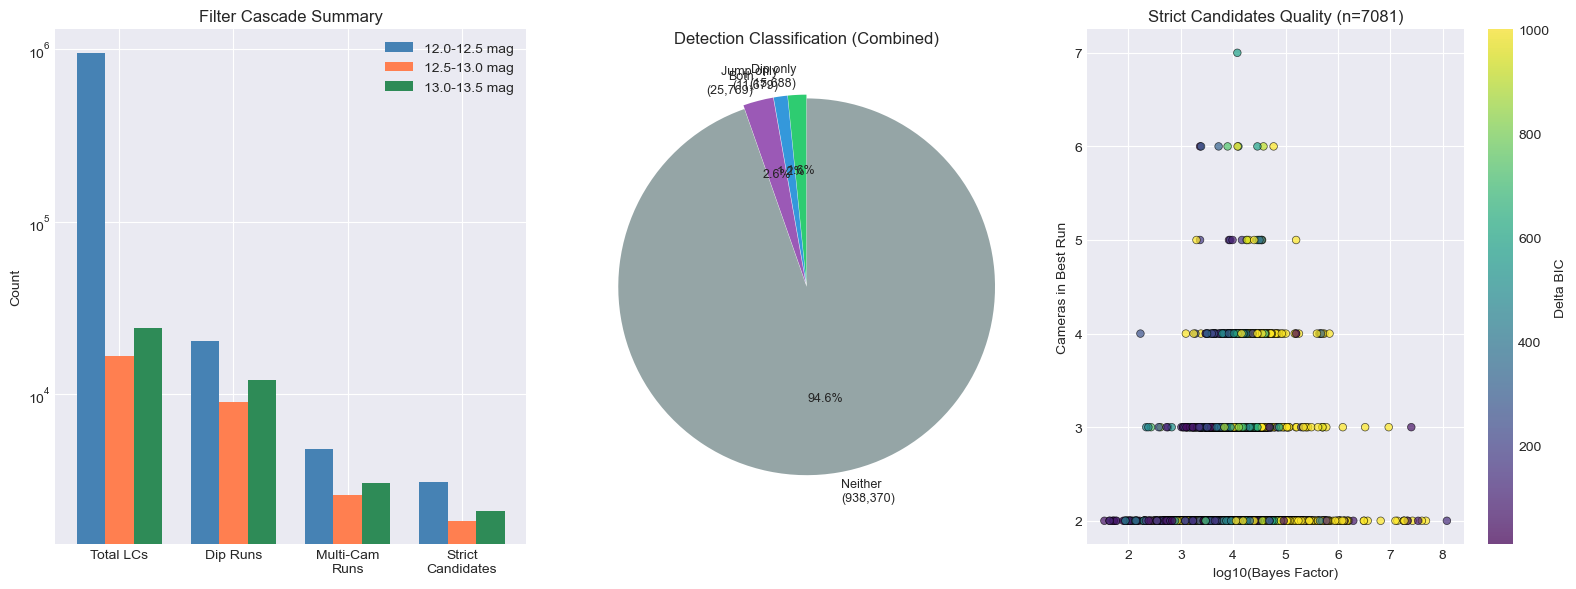

In [32]:
# Final summary visualization
fig = plt.figure(figsize=(16, 6))

# Create a summary bar chart
ax1 = fig.add_subplot(131)
categories = ['Total LCs', 'Dip Runs', 'Multi-Cam\nRuns', 'Strict\nCandidates']

bright_vals = [
    len(df_bright),
    (df_bright['dip_run_count'] >= 1).sum(),
    ((df_bright['dip_run_count'] >= 1) & (df_bright['dip_max_run_cameras'] >= 2)).sum(),
    len(candidates_strict[candidates_strict['mag_bin'] == '12.0-12.5']) if 'mag_bin' in candidates_strict.columns else 0
]

mid_vals = [
    len(df_mid),
    (df_mid['dip_run_count'] >= 1).sum(),
    ((df_mid['dip_run_count'] >= 1) & (df_mid['dip_max_run_cameras'] >= 2)).sum(),
    len(candidates_strict[candidates_strict['mag_bin'] == '12.5-13.0']) if 'mag_bin' in candidates_strict.columns else 0
]

faint_vals = [
    len(df_faint),
    (df_faint['dip_run_count'] >= 1).sum(),
    ((df_faint['dip_run_count'] >= 1) & (df_faint['dip_max_run_cameras'] >= 2)).sum(),
    len(candidates_strict[candidates_strict['mag_bin'] == '13.0-13.5']) if 'mag_bin' in candidates_strict.columns else 0
]

x = np.arange(len(categories))
width = 0.25

ax1.bar(x - width, bright_vals, width, label='12.0-12.5 mag', color='steelblue')
ax1.bar(x, mid_vals, width, label='12.5-13.0 mag', color='coral')
ax1.bar(x + width, faint_vals, width, label='13.0-13.5 mag', color='seagreen')

ax1.set_ylabel('Count')
ax1.set_title('Filter Cascade Summary')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.set_yscale('log')

# Detection significance pie chart
ax2 = fig.add_subplot(132)
total = len(df_combined)
dip_only = ((df_combined['dip_significant']) & (~df_combined['jump_significant'])).sum()
jump_only = ((~df_combined['dip_significant']) & (df_combined['jump_significant'])).sum()
both = ((df_combined['dip_significant']) & (df_combined['jump_significant'])).sum()
neither = ((~df_combined['dip_significant']) & (~df_combined['jump_significant'])).sum()

sizes = [dip_only, jump_only, both, neither]
labels = [f'Dip only\n({dip_only:,})', f'Jump only\n({jump_only:,})', 
          f'Both\n({both:,})', f'Neither\n({neither:,})']
colors = ['#2ecc71', '#3498db', '#9b59b6', '#95a5a6']
explode = (0.02, 0.02, 0.02, 0)

ax2.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', 
        startangle=90, textprops={'fontsize': 9})
ax2.set_title('Detection Classification (Combined)')

# Candidate quality scatter
ax3 = fig.add_subplot(133)
if len(candidates_strict) > 0:
    sc = ax3.scatter(
        np.log10(candidates_strict['dip_bayes_factor']),
        candidates_strict['dip_max_run_cameras'],
        c=candidates_strict['dip_best_delta_bic'].clip(upper=1000),
        cmap='viridis', alpha=0.7, s=30, edgecolors='black', linewidths=0.5
    )
    plt.colorbar(sc, ax=ax3, label='Delta BIC')
    ax3.set_xlabel('log10(Bayes Factor)')
    ax3.set_ylabel('Cameras in Best Run')
    ax3.set_title(f'Strict Candidates Quality (n={len(candidates_strict)})')
else:
    ax3.text(0.5, 0.5, 'No strict candidates', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Strict Candidates Quality')

plt.tight_layout()
plt.show()